# Rollout Analysis

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from typing import Dict, List, Optional, Union, Tuple
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Configuration
DATA_DIR = "./test_output_8rows/attention"
RESULTS_CSV = "./test_output_8rows/results_llama.csv"
TOKEN_METADATA_JSON = "./test_output_8rows/token_metadata_llama.json"

# Processing parameters
MAX_ROWS_TO_PROCESS = 10 #None
PROCESS_ALL_PROMPTS = True

##  Load Raw Attention Weights
Load `.npy` attention matrices into lists preserving original shape `[1, heads, seq, seq]`


In [ ]:
class RawAttentionLoader:
    """Load raw attention weights preserving original structure"""

    def __init__(self, data_dir: str, results_csv: str, token_metadata_json: Optional[str] = None):
        self.data_dir = data_dir
        self.results_df = pd.read_csv(results_csv)

        # Load token metadata
        self.token_metadata = None
        if token_metadata_json and os.path.exists(token_metadata_json):
            with open(token_metadata_json, 'r') as f:
                self.token_metadata = json.load(f)

        # File system mapping
        self.prompt_mapping = {
            'Prompt_1': 'prompt_1',
            'Prompt_2': 'prompt_2',
            'Prompt_3': 'prompt_3'
        }

        # Data storage - preserve raw attention weights
        self.raw_attention_data = {}
        self.token_data = {}
        self.validation_log = []

        
    def load_raw_attention_layer(self, row_idx: int, prompt_name: str, layer_idx: int) -> Optional[np.ndarray]:
        """
        Load raw attention matrix for a single layer

        Args:
            row_idx: Row index
            prompt_name: Prompt file name (e.g., 'prompt_1')
            layer_idx: Layer index

        Returns:
            attention: Raw attention matrix [1, heads, seq, seq] or None if not found
        """
        file_path = os.path.join(self.data_dir, f"row_{row_idx}", prompt_name, f"attn_layer_{layer_idx}.npy")

        if not os.path.exists(file_path):
            return None

        try:
            attention = np.load(file_path)

            # Validate shape - should be [1, heads, seq, seq]
            if len(attention.shape) != 4:
                self.validation_log.append(f"Invalid shape {attention.shape} for {file_path}")
                return None

            # Validate that attention weights sum to 1 (approximately)
            batch_size, num_heads, seq_len, key_len = attention.shape
            for b in range(batch_size):
                for h in range(num_heads):
                    for q in range(seq_len):
                        row_sum = np.sum(attention[b, h, q, :])
                        if not (0.99 <= row_sum <= 1.01):
                            # If not normalized, this is expected raw attention
                            pass

            return attention

        except Exception as e:
            self.validation_log.append(f"Error loading {file_path}: {e}")
            return None

        
    def extract_tokens(self, row_idx: int, prompt_col: str) -> List[str]:
        """Extract tokens from metadata"""
        if self.token_metadata is None:
            return []

        try:
            # Handle metadata structure variations
            if isinstance(self.token_metadata, list):
                if row_idx < len(self.token_metadata):
                    row_metadata = self.token_metadata[row_idx]
                else:
                    return []
            else:
                row_metadata = self.token_metadata.get(str(row_idx)) or self.token_metadata.get(row_idx)
                if not row_metadata:
                    return []

            # Extract token sequence
            if isinstance(row_metadata, dict) and prompt_col in row_metadata:
                tokens = row_metadata[prompt_col].get('sliced_tokens', [])
            elif isinstance(row_metadata, dict) and 'sliced_tokens' in row_metadata:
                tokens = row_metadata.get('sliced_tokens', [])
            else:
                return []

            # Clean tokenizer artifacts
            return [str(token).replace('Ġ', '').replace('▁', '').replace('##', '') for token in tokens]

        except Exception:
            return []

        
    def detect_layer_structure(self) -> int:
        """Detect number of layers in dataset"""
        max_layers = 0

        # Sample first few rows to detect structure
        for row_idx in range(min(5, len(self.results_df))):
            row = self.results_df.iloc[row_idx]

            for prompt_col in ['Prompt_1', 'Prompt_2', 'Prompt_3']:
                if pd.notna(row[prompt_col]) and str(row[prompt_col]).strip() != "No prompt":
                    prompt_file_name = self.prompt_mapping[prompt_col]
                    row_dir = os.path.join(self.data_dir, f"row_{row_idx}", prompt_file_name)

                    if os.path.exists(row_dir):
                        npy_files = [f for f in os.listdir(row_dir)
                                   if f.endswith('.npy') and 'attn_layer_' in f]

                        if npy_files:
                            max_layers = max(max_layers, len(npy_files))
                            break

        return max_layers

    
    def load_prompt_attention_layers(self, row_idx: int, prompt_col: str) -> Dict:
        """
        Load all attention layers for a single prompt

        Args:
            row_idx: Row index
            prompt_col: Prompt column (e.g., 'Prompt_1')

        Returns:
            prompt_data: Dictionary with raw attention layers and tokens
        """
        prompt_file_name = self.prompt_mapping[prompt_col]
        num_layers = self.detect_layer_structure()

        prompt_data = {
            'raw_attention_layers': [],  # List of [1, heads, seq, seq] matrices
            'tokens': self.extract_tokens(row_idx, prompt_col),
            'num_layers': 0,
            'attention_shape': None
        }

        # Load each layer
        for layer_idx in range(num_layers):
            attention = self.load_raw_attention_layer(row_idx, prompt_file_name, layer_idx)

            if attention is not None:
                prompt_data['raw_attention_layers'].append(attention)
                prompt_data['num_layers'] += 1

                if prompt_data['attention_shape'] is None:
                    prompt_data['attention_shape'] = attention.shape

        # Convert to numpy array if we have layers
        if prompt_data['raw_attention_layers']:
            # Stack layers: [num_layers, 1, heads, seq, seq]
            stacked_attention = np.stack(prompt_data['raw_attention_layers'], axis=0)
            # Remove batch dimension: [num_layers, heads, seq, seq]
            prompt_data['raw_attention_weights'] = stacked_attention.squeeze(axis=1)
        else:
            prompt_data['raw_attention_weights'] = None

        return prompt_data

    
    def load_dataset(self, max_rows: Optional[int] = None) -> Dict:
        """
        Load raw attention data for entire dataset

        Args:
            max_rows: Maximum rows to process

        Returns:
            all_raw_data: Dictionary with raw attention data
        """
        processing_limit = min(max_rows or len(self.results_df), len(self.results_df))

        stats = {
            'rows_processed': 0,
            'prompts_processed': 0,
            'layers_loaded': 0,
            'rows_with_data': 0
        }

        for row_idx in range(processing_limit):
            row = self.results_df.iloc[row_idx]
            row_has_data = False

            self.raw_attention_data[row_idx] = {}

            prompts_to_process = ['Prompt_1', 'Prompt_2', 'Prompt_3'] if PROCESS_ALL_PROMPTS else ['Prompt_1']

            for prompt_col in prompts_to_process:
                if pd.notna(row[prompt_col]) and str(row[prompt_col]).strip() != "No prompt":
                    prompt_data = self.load_prompt_attention_layers(row_idx, prompt_col)

                    if prompt_data['raw_attention_weights'] is not None:
                        self.raw_attention_data[row_idx][prompt_col] = prompt_data
                        stats['prompts_processed'] += 1
                        stats['layers_loaded'] += prompt_data['num_layers']
                        row_has_data = True

            if row_has_data:
                stats['rows_with_data'] += 1

            stats['rows_processed'] += 1

        return stats

    
    def get_summary(self) -> Dict:
        """Generate processing summary"""
        if not self.raw_attention_data:
            return {"error": "No data loaded"}

        total_rows = len(self.raw_attention_data)
        total_prompts = sum(len(prompts) for prompts in self.raw_attention_data.values())

        # Get sample attention shape
        sample_shape = None
        sample_num_layers = 0
        for row_data in self.raw_attention_data.values():
            for prompt_data in row_data.values():
                if prompt_data['raw_attention_weights'] is not None:
                    sample_shape = prompt_data['raw_attention_weights'].shape
                    sample_num_layers = prompt_data['num_layers']
                    break
            if sample_shape:
                break

        return {
            'dataset_size': len(self.results_df),
            'rows_with_data': total_rows,
            'total_prompts': total_prompts,
            'sample_attention_shape': sample_shape,  # [num_layers, heads, seq, seq]
            'sample_num_layers': sample_num_layers,
            'has_token_metadata': self.token_metadata is not None,
            'validation_issues': len(self.validation_log)
        }


### DIAGNOSTIC FUNCTIONS ###    
# Function to diagnose the entire dataset structure
def validate_single_attention_file(file_path: str) -> Dict:
    """
    Load and validate a single attention file to understand its structure
    """
    try:
        attention = np.load(file_path)

        validation_info = {
            'file_path': file_path,
            'shape': attention.shape,
            'dtype': attention.dtype,
            'min_val': float(attention.min()),
            'max_val': float(attention.max()),
            'has_nan': bool(np.any(np.isnan(attention))),
            'has_inf': bool(np.any(np.isinf(attention))),
        }

        # Check if this looks like proper attention weights
        if len(attention.shape) == 4:
            batch, heads, seq_len, key_len = attention.shape

            # Sample a few attention rows to check if they sum to ~1
            sample_sums = []
            for b in range(min(1, batch)):
                for h in range(min(3, heads)):
                    for q in range(min(5, seq_len)):
                        row_sum = np.sum(attention[b, h, q, :key_len])
                        sample_sums.append(row_sum)

            validation_info.update({
                'batch_size': batch,
                'num_heads': heads,
                'seq_len': seq_len,
                'key_len': key_len,
                'sample_row_sums': sample_sums[:5],
                'mean_row_sum': float(np.mean(sample_sums)),
                'looks_like_attention': 0.9 <= np.mean(sample_sums) <= 1.1
            })

        return validation_info

    except Exception as e:
        return {
            'file_path': file_path,
            'error': str(e)
        }


def diagnose_attention_structure(data_dir: str, max_rows: int = 3, max_layers: int = 3):
    """
    Diagnose the attention file structure across multiple rows and layers
    """
    print("=== ATTENTION STRUCTURE DIAGNOSIS ===")

    for row_idx in range(max_rows):
        print(f"\nRow {row_idx}:")

        for prompt_name in ['prompt_1', 'prompt_2', 'prompt_3']:
            row_dir = os.path.join(data_dir, f"row_{row_idx}", prompt_name)

            if os.path.exists(row_dir):
                print(f"  {prompt_name}:")

                for layer_idx in range(max_layers):
                    file_path = os.path.join(row_dir, f"attn_layer_{layer_idx}.npy")

                    if os.path.exists(file_path):
                        validation = validate_single_attention_file(file_path)

                        if 'error' in validation:
                            print(f"    Layer {layer_idx}: ERROR - {validation['error']}")
                        else:
                            shape = validation['shape']
                            looks_good = validation.get('looks_like_attention', False)
                            status = "✓" if looks_good else "⚠"
                            print(f"    Layer {layer_idx}: {shape} {status}")

                            if 'mean_row_sum' in validation:
                                print(f"      Row sum avg: {validation['mean_row_sum']:.3f}")
                    else:
                        print(f"    Layer {layer_idx}: Missing")
            else:
                print(f"  {prompt_name}: Directory missing")


### MAIN LOADING METHOD
if __name__ == "__main__":
    diagnose_attention_structure(DATA_DIR, max_rows=2, max_layers=3)


    print("Raw Attention Weight Loading")
    print("-" * 40)

    # Initialize loader
    loader = RawAttentionLoader(DATA_DIR, RESULTS_CSV, TOKEN_METADATA_JSON)

    print(f"Dataset: {len(loader.results_df)} rows")
    print(f"Processing up to {MAX_ROWS_TO_PROCESS} rows")

    # Load dataset
    loading_stats = loader.load_dataset(max_rows=MAX_ROWS_TO_PROCESS)

    # Generate summary
    summary = loader.get_summary()

    print(f"\nLoading Results:")
    print(f"  Rows with attention data: {summary['rows_with_data']}")
    print(f"  Total prompts loaded: {summary['total_prompts']}")

    if summary['sample_attention_shape']:
        shape = summary['sample_attention_shape']
        print(f"  Attention shape: {shape}")
        print(f"  Number of layers: {shape[0]}")
        print(f"  Number of heads: {shape[1]}")
        print(f"  Sequence length: {shape[2]}")
        print(f"  Token length: {len(tokens)}")

    if summary['validation_issues'] > 0:
        print(f"  Validation issues: {summary['validation_issues']}")

    # Export for subsequent scripts
    globals()['raw_attention_loader'] = loader
    globals()['raw_attention_data'] = loader.raw_attention_data
    globals()['dataset_df'] = loader.results_df

    print(f"\nRaw attention weights loaded and ready for processing")


## Preprocess layers
Average over heads: `W^l_att = mean(attn^l, axis=1)`

Add residual: `A^l = 0.5 * W^l_att + 0.5 * I (I = np.eye(seq_len))`

In [3]:
# Configuration
RESIDUAL_WEIGHT = 0.5  # Weight for residual connection

class AttentionLayerProcessor:
    """Process attention layers by averaging heads and adding residual connections"""

    def __init__(self, residual_weight: float = 0.5):
        self.residual_weight = residual_weight
        self.processed_data = {}
        self.processing_stats = {}

        
    def average_attention_heads(self, layer_attention: np.ndarray) -> np.ndarray:
        """
        Average attention weights over heads

        Args:
            layer_attention: Raw attention for single layer [heads, seq, seq]

        Returns:
            averaged_attention: Head-averaged attention [seq, seq]
        """
        # Average over heads (axis=0)
        return np.mean(layer_attention, axis=0)

    
    def add_residual_connection(self, attention_matrix: np.ndarray) -> np.ndarray:

        """
        Add residual connection with fixed weighting
        - A^l = (1-w) * W^l_att + w * I where w is small
        """
        seq_len = attention_matrix.shape[0]
        identity_matrix = np.eye(seq_len)

        # Use complementary weights so they sum to 1
        attention_weight = 1.0 - self.residual_weight  # 0.9
        residual_weight = self.residual_weight         # 0.1

        # A^l = 0.9 * W^l_att + 0.1 * I
        residual_attention = (attention_weight * attention_matrix +
                          residual_weight * identity_matrix)

        return residual_attention
    
    
    def process_single_layer(self, layer_attention: np.ndarray) -> np.ndarray:
        """
        Process single attention layer: average heads + add residual

        Args:
            layer_attention: Raw attention for single layer [heads, seq, seq]

        Returns:
            processed_layer: Processed attention [seq, seq]
        """
        # Step 1: Average over heads
        averaged_attention = self.average_attention_heads(layer_attention)

        # Step 2: Add residual connection
        processed_layer = self.add_residual_connection(averaged_attention)

        return processed_layer

    
    def process_prompt_layers(self, prompt_data: Dict) -> Dict:
        """
        Process all layers for a single prompt

        Args:
            prompt_data: Raw attention data for prompt from Script 1

        Returns:
            processed_prompt: Processed attention data
        """
        if prompt_data is None or prompt_data['raw_attention_weights'] is None:
            return None

        raw_attention = prompt_data['raw_attention_weights']  # [num_layers, heads, seq, seq]
        tokens = prompt_data['tokens']

        processed_layers = []

        # Process each layer
        for layer_idx in range(raw_attention.shape[0]):
            layer_attention = raw_attention[layer_idx]  # [heads, seq, seq]
            processed_layer = self.process_single_layer(layer_attention)
            processed_layers.append(processed_layer)

        # Stack processed layers
        processed_attention_stack = np.stack(processed_layers, axis=0)  # [num_layers, seq, seq]

        processed_prompt = {
            'raw_attention_weights': raw_attention,  # Keep original for reference
            'processed_attention_layers': processed_attention_stack,  # [num_layers, seq, seq]
            'tokens': tokens,
            'num_layers': len(processed_layers),
            'sequence_length': processed_attention_stack.shape[1],
            'processing_method': {
                'head_averaging': 'mean',
                'residual_weight': self.residual_weight,
                'residual_formula': f'A^l = {self.residual_weight} * W^l_att + {self.residual_weight} * I'
            }
        }

        return processed_prompt

    
    def process_dataset(self, raw_attention_data: Dict) -> Dict:
        """
        Process attention layers for entire dataset

        Args:
            raw_attention_data: Raw attention data from Script 1

        Returns:
            all_processed_data: Processed attention data
        """
        all_processed_data = {}

        processing_stats = {
            'total_prompts': 0,
            'successful_processing': 0,
            'failed_processing': 0,
            'total_layers_processed': 0
        }

        for row_idx, row_data in raw_attention_data.items():
            all_processed_data[row_idx] = {}

            for prompt_col, prompt_data in row_data.items():
                processing_stats['total_prompts'] += 1

                try:
                    processed_prompt = self.process_prompt_layers(prompt_data)

                    if processed_prompt is not None:
                        all_processed_data[row_idx][prompt_col] = processed_prompt
                        processing_stats['successful_processing'] += 1
                        processing_stats['total_layers_processed'] += processed_prompt['num_layers']
                    else:
                        all_processed_data[row_idx][prompt_col] = None
                        processing_stats['failed_processing'] += 1

                except Exception as e:
                    print(f"Error processing {row_idx}/{prompt_col}: {e}")
                    all_processed_data[row_idx][prompt_col] = None
                    processing_stats['failed_processing'] += 1

        self.processing_stats = processing_stats
        return all_processed_data

    def validate_processing(self, processed_data: Dict) -> Dict:
        """
        Validate that processing was successful

        Args:
            processed_data: Processed attention data

        Returns:
            validation_results: Validation statistics
        """
        validation = {
            'valid_prompts': 0,
            'invalid_prompts': 0,
            'residual_connection_check': [],
            'shape_consistency': True,
            'sequence_lengths': set()
        }

        for row_idx, row_data in processed_data.items():
            for prompt_col, prompt_result in row_data.items():
                if prompt_result is not None:
                    validation['valid_prompts'] += 1

                    # Check residual connection effect
                    processed_layers = prompt_result['processed_attention_layers']

                    # Check that diagonal elements are enhanced (due to identity addition)
                    for layer_idx in range(processed_layers.shape[0]):
                        layer = processed_layers[layer_idx]
                        diagonal_mean = np.mean(np.diag(layer))
                        off_diagonal_mean = np.mean(layer - np.diag(np.diag(layer)))

                        # Diagonal should be higher due to residual connection
                        validation['residual_connection_check'].append({
                            'layer_idx': layer_idx,
                            'diagonal_mean': diagonal_mean,
                            'off_diagonal_mean': off_diagonal_mean,
                            'residual_effect': diagonal_mean > off_diagonal_mean
                        })

                    # Check sequence length consistency
                    validation['sequence_lengths'].add(prompt_result['sequence_length'])

                else:
                    validation['invalid_prompts'] += 1

        # Summary statistics
        if validation['residual_connection_check']:
            residual_effects = [check['residual_effect'] for check in validation['residual_connection_check']]
            validation['residual_effect_success_rate'] = np.mean(residual_effects)

        validation['sequence_lengths'] = sorted(list(validation['sequence_lengths']))

        return validation

    def get_processing_summary(self, processed_data: Dict) -> Dict:
        """
        Get summary of processing results

        Args:
            processed_data: Processed attention data

        Returns:
            summary: Processing summary
        """
        validation = self.validate_processing(processed_data)

        summary = {
            'processing_stats': self.processing_stats,
            'validation_results': validation,
            'configuration': {
                'residual_weight': self.residual_weight,
                'processing_formula': f'A^l = {self.residual_weight} * mean(attn^l, axis=heads) + {self.residual_weight} * I'
            }
        }

        return summary

# Execute layer processing
if __name__ == "__main__":
    print("Attention Layer Processing")
    print("-" * 40)

    # Check if raw attention data is available from Script 1
    if 'raw_attention_data' not in globals():
        print("Error: No raw attention data found. Run Script 1 first.")
        exit()

    # Initialize processor
    processor = AttentionLayerProcessor(residual_weight=RESIDUAL_WEIGHT)

    print(f"Processing layers with residual weight: {RESIDUAL_WEIGHT}")
    print(f"Formula: A^l = {RESIDUAL_WEIGHT} * W^l_att + {RESIDUAL_WEIGHT} * I")

    # Process all data
    all_processed_data = processor.process_dataset(raw_attention_data)

    # Get processing summary
    summary = processor.get_processing_summary(all_processed_data)

    print(f"\nProcessing Results:")
    stats = summary['processing_stats']
    print(f"  Total prompts: {stats['total_prompts']}")
    print(f"  Successful processing: {stats['successful_processing']}")
    print(f"  Failed processing: {stats['failed_processing']}")
    print(f"  Total layers processed: {stats['total_layers_processed']}")

    # Validation results
    validation = summary['validation_results']
    print(f"\nValidation Results:")
    print(f"  Valid prompts: {validation['valid_prompts']}")
    print(f"  Invalid prompts: {validation['invalid_prompts']}")
    print(f"  Unique sequence lengths: {validation['sequence_lengths']}")

    if 'residual_effect_success_rate' in validation:
        print(f"  Residual connection effect success rate: {validation['residual_effect_success_rate']:.2%}")

    # Export for subsequent scripts
    globals()['all_processed_data'] = all_processed_data
    globals()['layer_processor'] = processor
    globals()['processing_summary'] = summary

    print(f"\nLayer processing completed and ready for rollout computation")

Attention Layer Processing
----------------------------------------
Processing layers with residual weight: 0.5
Formula: A^l = 0.5 * W^l_att + 0.5 * I

Processing Results:
  Total prompts: 20
  Successful processing: 20
  Failed processing: 0
  Total layers processed: 320

Validation Results:
  Valid prompts: 20
  Invalid prompts: 0
  Unique sequence lengths: [74, 116, 117, 121, 124, 126, 130, 139, 140, 141, 142, 145, 161, 181, 201, 209, 248]
  Residual connection effect success rate: 100.00%

Layer processing completed and ready for rollout computation


## Proper Rollout Computation

We're inputting the set of processed prompts where:
```
processed_prompt = {
            'raw_attention_weights': raw_attention,  # Keep original for reference
            'processed_attention_layers': processed_attention_stack,  # [num_layers, seq, seq]
            'tokens': tokens,
            'num_layers': len(processed_layers),
            'sequence_length': processed_attention_stack.shape[1],
            'processing_method': {
                'head_averaging': 'mean',
                'residual_weight': self.residual_weight,
                'residual_formula': f'A^l = {self.residual_weight} * W^l_att + {self.residual_weight} * I'
            }
        }
```
and returning the computation of the rollout.


In [4]:


class FixedRolloutComputer:
    """Compute attention rollout following bert_viz methodology exactly"""

    def __init__(self, save_history: bool = True):
        self.save_history = save_history
        self.rollout_data = {}
        self.computation_stats = {}

    def compute_rollout_bert_viz_style(self, processed_layers: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        """
        Computers rollout

        Args:
            processed_layers: Processed attention [num_layers, seq, seq]

        Returns:
            final_rollout: Final rollout matrix [seq, seq]
            rollout_history: History of rollout computation [num_layers, seq, seq]
        """
        num_layers, seq_len, _ = processed_layers.shape

        # Initialize with identity matrix
        rollout = np.eye(seq_len, dtype=np.float32)
        rollout_history = [rollout.copy()] if self.save_history else None

        for layer_idx in range(num_layers):
            # Get attention for this layer
            attention_layer = processed_layers[layer_idx]  # [seq, seq]
            # Fully correct in accordance with the paper
            rollout = np.matmul(attention_layer, rollout)

            if self.save_history:
                rollout_history.append(rollout.copy())

        return rollout, rollout_history

    
    def compute_rollout_alternative_method(self, processed_layers: np.ndarray) -> Tuple[np.ndarray, List[np.ndarray]]:
        """
        TODO: Debug and add to mixed run!
        
        Alternative rollout computation that prevents BOS token dominance

        Args:
            processed_layers: Processed attention [num_layers, seq, seq]

        Returns:
            final_rollout: Final rollout matrix
            rollout_history: History of rollout computation
        """
        num_layers, seq_len, _ = processed_layers.shape

        # Method 2: Joint attention (average across layers)
        # More stable and prevents begin token dominance - TODO : WHY???
        rollout = np.mean(processed_layers, axis=0)

        # Ensure proper normalization
        row_sums = np.sum(rollout, axis=1, keepdims=True)
        row_sums = np.maximum(row_sums, 1e-8)  # Prevent division by zero
        rollout = rollout / row_sums

        rollout_history = [np.eye(seq_len), rollout] if self.save_history else None

        return rollout, rollout_history

    def compute_rollout_mixed_method(self, processed_layers: np.ndarray, method: str = 'bert_viz') -> Tuple[np.ndarray, List[np.ndarray]]:
        """
        Try different rollout computation methods

        Args:
            processed_layers: Processed attention [num_layers, seq, seq]
            method: 'bert_viz', 'alternative', or 'mixed'

        Returns:
            final_rollout: Final rollout matrix
            rollout_history: History of rollout computation
        """
        if method == 'bert_viz':
            return self.compute_rollout_bert_viz_style(processed_layers)
        elif method == 'alternative':
            return self.compute_rollout_alternative_method(processed_layers)
        elif method == 'mixed':
            # Try bert_viz first, fall back to alternative if begin token dominance
            rollout_bv, history_bv = self.compute_rollout_bert_viz_style(processed_layers)

            # Check for begin token dominance
            begin_token_attention = np.mean(rollout_bv[:, 0])

            if begin_token_attention > 0.8:  # Too much attention to begin token
                return self.compute_rollout_alternative_method(processed_layers)
            else:
                return rollout_bv, history_bv
        else:
            raise ValueError(f"Unknown method: {method}")

    def compute_rollout_for_prompt(self, processed_prompt: Dict, method: str = 'bert_viz') -> Dict:
        """
        Compute rollout for prompt with multiple methods

        Args:
            processed_prompt: Processed attention data from Script 2
            method: Rollout computation method

        Returns:
            rollout_result: Rollout computation results
        """
        if processed_prompt is None:
            return None

        processed_layers = processed_prompt['processed_attention_layers']  # [num_layers, seq, seq]
        tokens = processed_prompt['tokens']
        num_layers, seq_len, _ = processed_layers.shape

        # Compute rollout using specified method
        final_rollout, rollout_history = self.compute_rollout_mixed_method(processed_layers, method)

        rollout_result = {
            'final_rollout': final_rollout,
            'rollout_history': rollout_history,
            'tokens': tokens,
            'num_layers': num_layers,
            'sequence_length': seq_len,
            'computation_method': method,
            'raw_attention_weights': processed_prompt.get('raw_attention_weights'),  # Preserve raw attention
            # Add quality metrics
            'begin_token_dominance': float(np.mean(final_rollout[:, 0])),
            'attention_distribution_entropy': float(-np.sum(np.mean(final_rollout, axis=0) * np.log(np.mean(final_rollout, axis=0) + 1e-10)))
        }

        return rollout_result

    def compute_dataset_rollouts_fixed(self, all_processed_data: Dict, method: str = 'bert_viz') -> Dict:
        """
        Compute rollouts for entire dataset with improved method
        (hard fixed to bert_viz for now until mixed method is debugged)

        Args:
            all_processed_data: Processed attention data from Script 2
            method: Rollout computation method

        Returns:
            all_rollout_data: Rollout results for entire dataset
        """
        
        all_rollout_data = {}

        computation_stats = {
            'total_prompts': 0,
            'successful_rollouts': 0,
            'failed_rollouts': 0,
            'method_used': method,
            'begin_token_dominance_cases': 0,
            'alternative_method_used': 0
        }

        for row_idx, row_data in all_processed_data.items():
            all_rollout_data[row_idx] = {}

            for prompt_col, processed_prompt in row_data.items():
                computation_stats['total_prompts'] += 1

                try:
                    rollout_result = self.compute_rollout_for_prompt(processed_prompt, method)

                    if rollout_result is not None:
                        all_rollout_data[row_idx][prompt_col] = rollout_result
                        computation_stats['successful_rollouts'] += 1

                        # Track statistics
                        if rollout_result['begin_token_dominance'] > 0.8:
                            computation_stats['begin_token_dominance_cases'] += 1

                        if 'alternative' in rollout_result.get('computation_method', ''):
                            computation_stats['alternative_method_used'] += 1

                    else:
                        all_rollout_data[row_idx][prompt_col] = None
                        computation_stats['failed_rollouts'] += 1

                except Exception as e:
                    all_rollout_data[row_idx][prompt_col] = None
                    computation_stats['failed_rollouts'] += 1

        self.computation_stats = computation_stats
        return all_rollout_data

    
# Main method
if __name__ == "__main__":
    print("Rollout Computation")
    print("-" * 40)

    # Check if processed data is available from Script 2
    if 'all_processed_data' not in globals():
        print("Error: No processed attention data found. Run Script 2 first.")
        exit()

    # Initialize FIXED rollout computer
    fixed_rollout_computer = FixedRolloutComputer(save_history=True)

    print(f"Computing rollouts for {len(all_processed_data)} rows")

    # Compute rollouts with FIXED method
    all_rollout_data_fixed = fixed_rollout_computer.compute_dataset_rollouts_fixed(
        all_processed_data, method='bert_viz'
    )

    # Get computation statistics
    stats = fixed_rollout_computer.computation_stats

    print(f"\n Rollout Results:")
    print(f"  Successful rollouts: {stats['successful_rollouts']}")
    print(f"  Begin token dominance cases: {stats['begin_token_dominance_cases']}")
    print(f"  Alternative method used: {stats['alternative_method_used']}")

    # Show improvement for first sample
    for row_idx, row_data in all_rollout_data_fixed.items():
        for prompt_col, rollout_result in row_data.items():
            if rollout_result:
                tokens = rollout_result['tokens']
                dominance = rollout_result['begin_token_dominance']

                print(f"\nSample: Row {row_idx}, {prompt_col}")
                print(f"  Begin token ('{tokens[0]}') dominance: {dominance:.4f}")

                # Show top attended tokens
                final_rollout = rollout_result['final_rollout']
                avg_attention = np.mean(final_rollout, axis=0)
                top_indices = np.argsort(avg_attention)[-3:][::-1]

                print(f"  Top 3 attended tokens:")
                for i, idx in enumerate(top_indices):
                    if idx < len(tokens):
                        print(f"    {i+1}. '{tokens[idx]}': {avg_attention[idx]:.4f}")
                break
        break

    # Replace the old rollout data
    globals()['all_rollout_data'] = all_rollout_data_fixed
    globals()['fixed_rollout_computer'] = fixed_rollout_computer


FIXED Rollout Computation
----------------------------------------
Computing FIXED rollouts for 8 rows

FIXED Rollout Results:
  Successful rollouts: 20
  Begin token dominance cases: 0
  Alternative method used: 0

Sample: Row 0, Prompt_1
  Begin token (':Ċ') dominance: 0.0001
  Top 3 attended tokens:
    1. 'age': 0.0001
    2. 'The': 0.0001
    3. 'man': 0.0001


## Rollout Normalization

Input is all_rollout_data which is made up of rows that look like
```
rollout_result = {
            'final_rollout': final_rollout,
            'rollout_history': rollout_history,
            'tokens': tokens,
            'num_layers': num_layers,
            'sequence_length': seq_len,
            'computation_method': method,
            'raw_attention_weights': processed_prompt.get('raw_attention_weights'),  # Preserve raw attention
            # Add quality metrics
            'begin_token_dominance': float(np.mean(final_rollout[:, 0])),
            'attention_distribution_entropy': float(-np.sum(np.mean(final_rollout, axis=0) * np.log(np.mean(final_rollout, axis=0) + 1e-10)))
        }
```
and outputs the normalized rollout

In [5]:
# Configuration
EPSILON = 1e-8  # Small value to prevent division by zero

class RolloutNormalizer:
    """Normalize rollout matrices to probability distributions"""

    def __init__(self, epsilon: float = 1e-8):
        self.epsilon = epsilon
        self.normalized_data = {}
        self.normalization_stats = {}

        
    def row_normalize_rollout(self, rollout: np.ndarray) -> np.ndarray:
        """
        Row-normalize rollout matrix: rollout[i] /= sum(rollout[i])

        Args:
            rollout: Rollout matrix [seq_len, seq_len]

        Returns:
            normalized_rollout: Row-normalized matrix [seq_len, seq_len]
        """
        # Compute row sums
        row_sums = np.sum(rollout, axis=1, keepdims=True)

        # Handle zero rows (add epsilon to prevent division by zero)
        row_sums = np.maximum(row_sums, self.epsilon)

        # Normalize each row to sum to 1
        normalized_rollout = rollout / row_sums

        return normalized_rollout

    
    def compute_attention_metrics(self, normalized_rollout: np.ndarray) -> Dict:
        """
        Compute attention analysis metrics from normalized rollout

        Args:
            normalized_rollout: Normalized rollout matrix [seq_len, seq_len]

        Returns:
            metrics: Dictionary of computed attention metrics
        """
        seq_len = normalized_rollout.shape[0]

        # Step 6 preparation: Compute metrics for analysis/visualization
        # Average rollout to key tokens (average attention each token receives)
        avg_attention_to_tokens = np.mean(normalized_rollout, axis=0)

        # Maximum attention values per position
        max_attention_values = np.max(normalized_rollout, axis=1)
        max_attention_indices = np.argmax(normalized_rollout, axis=1)

        # Attention entropy calculation
        epsilon = 1e-10
        probs = normalized_rollout + epsilon  # Add small epsilon to avoid log(0)
        attention_entropy = -np.sum(probs * np.log(probs), axis=1)

        # Attention concentration (inverse of entropy, normalized) UNSURE IF WE NEED THIS
        max_entropy = np.log(seq_len)
        attention_concentration = (max_entropy - attention_entropy) / max_entropy

        # Total attention flow
        total_attention_flow = np.sum(avg_attention_to_tokens)

        metrics = {
            'avg_attention_to_tokens': avg_attention_to_tokens,
            'max_attention_values': max_attention_values,
            'max_attention_indices': max_attention_indices,
            'attention_entropy': attention_entropy,
            'attention_concentration': attention_concentration,
            'total_attention_flow': total_attention_flow,
            'sequence_length': seq_len
        }

        return metrics

    
    def validate_normalization(self, normalized_rollout: np.ndarray, tolerance: float = 1e-6) -> Dict:
        """
        Validate that row-normalization was successful

        Args:
            normalized_rollout: Normalized rollout matrix
            tolerance: Tolerance for row sum validation

        Returns:
            validation: Validation results
        """
        validation = {
            'is_valid': True,
            'issues': [],
            'row_sum_stats': {},
            'value_range': {}
        }

        # Check that each row sums to 1
        row_sums = np.sum(normalized_rollout, axis=1)
        validation['row_sum_stats'] = {
            'mean': float(np.mean(row_sums)),
            'std': float(np.std(row_sums)),
            'min': float(np.min(row_sums)),
            'max': float(np.max(row_sums))
        }

        # Check if all row sums are approximately 1
        if not np.allclose(row_sums, 1.0, atol=tolerance):
            validation['is_valid'] = False
            validation['issues'].append(f"Row sums not equal to 1: range [{np.min(row_sums):.6f}, {np.max(row_sums):.6f}]")

        # Check value range [0, 1]
        validation['value_range'] = {
            'min': float(np.min(normalized_rollout)),
            'max': float(np.max(normalized_rollout)),
            'mean': float(np.mean(normalized_rollout))
        }

        if np.any(normalized_rollout < 0):
            validation['is_valid'] = False
            validation['issues'].append("Contains negative values")

        if np.any(normalized_rollout > 1 + tolerance):
            validation['is_valid'] = False
            validation['issues'].append("Contains values > 1")

        return validation


    def normalize_dataset_rollouts(self, all_rollout_data: Dict) -> Dict:
        """
        Normalize rollouts for entire dataset

        Args:
            all_rollout_data: Rollout data from Script 3

        Returns:
            all_normalized_data: Normalized rollouts with attention metrics
        """
        all_normalized_data = {}

        normalization_stats = {
            'total_prompts': 0,
            'successful_normalizations': 0,
            'failed_normalizations': 0,
            'validation_failures': 0
        }

        for row_idx, row_data in all_rollout_data.items():
            all_normalized_data[row_idx] = {}

            for prompt_col, rollout_result in row_data.items():
                normalization_stats['total_prompts'] += 1

                try:
                    normalized_result = self.normalize_prompt_rollout(rollout_result)

                    if normalized_result is not None:
                        all_normalized_data[row_idx][prompt_col] = normalized_result
                        normalization_stats['successful_normalizations'] += 1

                        # Check validation
                        if not normalized_result['validation']['is_valid']:
                            normalization_stats['validation_failures'] += 1
                    else:
                        all_normalized_data[row_idx][prompt_col] = None
                        normalization_stats['failed_normalizations'] += 1

                except Exception as e:
                    print(f"Error normalizing {row_idx}/{prompt_col}: {e}")
                    all_normalized_data[row_idx][prompt_col] = None
                    normalization_stats['failed_normalizations'] += 1

        self.normalization_stats = normalization_stats
        return all_normalized_data

    
    def get_dataset_metrics_summary(self, all_normalized_data: Dict) -> Dict:
        """
        Compute summary statistics across all normalized rollouts

        Args:
            all_normalized_data: Normalized rollout data

        Returns:
            summary: Aggregated metrics summary
        """
        summary = {
            'entropy_stats': [],
            'concentration_stats': [],
            'max_attention_stats': [],
            'total_flow_stats': [],
            'avg_attention_distributions': [],
            'sequence_lengths': set()
        }

        for row_idx, row_data in all_normalized_data.items():
            for prompt_col, normalized_result in row_data.items():
                if normalized_result and 'attention_metrics' in normalized_result:
                    metrics = normalized_result['attention_metrics']

                    # Collect per-position statistics
                    summary['entropy_stats'].extend(metrics['attention_entropy'].tolist())
                    summary['concentration_stats'].extend(metrics['attention_concentration'].tolist())
                    summary['max_attention_stats'].extend(metrics['max_attention_values'].tolist())

                    # Collect per-prompt statistics
                    summary['total_flow_stats'].append(metrics['total_attention_flow'])
                    summary['avg_attention_distributions'].append(metrics['avg_attention_to_tokens'])
                    summary['sequence_lengths'].add(normalized_result['sequence_length'])

        # Compute aggregate statistics
        for key in ['entropy_stats', 'max_attention_stats', 'total_flow_stats']: # 'concentration_stats'
            if summary[key]:
                values = np.array(summary[key])
                summary[key] = {
                    'mean': float(np.mean(values)),
                    'std': float(np.std(values)),
                    'min': float(np.min(values)),
                    'max': float(np.max(values)),
                    'median': float(np.median(values))
                }

        summary['sequence_lengths'] = sorted(list(summary['sequence_lengths']))

        return summary

    
    def get_normalization_summary(self, all_normalized_data: Dict) -> Dict:
        """
        Get summary of normalization process

        Args:
            all_normalized_data: Normalized data

        Returns:
            summary: Normalization summary
        """
        metrics_summary = self.get_dataset_metrics_summary(all_normalized_data)

        summary = {
            'normalization_stats': self.normalization_stats,
            'metrics_summary': metrics_summary,
            'configuration': {
                'epsilon': self.epsilon,
                'normalization_method': 'row_normalize',
                'formula': 'rollout[i] /= sum(rollout[i]) for each row i'
            }
        }

        return summary


    def normalize_prompt_rollout(self, rollout_result: Dict) -> Dict:
        """
        Normalize rollout result for a single prompt
        V august 15th - added rollout history
        """
        if rollout_result is None:
            return None

        final_rollout = rollout_result['final_rollout']

        # Step 5: Normalize rollout
        normalized_rollout = self.row_normalize_rollout(final_rollout)


        # NEW PLS DON"T DELETE: Normalize each entry in rollout_history
        rollout_history = rollout_result.get('rollout_history')
        if rollout_history is not None:
            normalized_history_list = [
                self.row_normalize_rollout(layer_rollout)
                for layer_rollout in rollout_history
            ]
            normalized_history_array = np.stack(normalized_history_list, axis=0)
        else:
            normalized_history_list = None
            normalized_history_array = None


        # Compute attention metrics for step 6
        attention_metrics = self.compute_attention_metrics(normalized_rollout)

        # Validate normalization
        validation = self.validate_normalization(normalized_rollout)

        # FIXED: Get raw attention from processed data if available
        raw_attention_weights = None
        if 'integrated_data' in globals():
          # Try to find raw attention from earlier scripts
            for row_idx, row_data in globals()['all_processed_data'].items():
                for prompt_col, processed_prompt in row_data.items():
                    if processed_prompt and 'raw_attention_weights' in processed_prompt:
                        raw_attention_weights = processed_prompt['raw_attention_weights']
                        break
                    if raw_attention_weights is not None:
                        break

    # Create normalized result with preserved raw attention
        normalized_result = {
            'original_rollout': final_rollout,
            'normalized_rollout': normalized_rollout,
            'normalized_rollout_history_list': normalized_history_list,   # list of matrices
            'normalized_rollout_history_array': normalized_history_array, # (layers, seq, seq)
            'attention_metrics': attention_metrics,
            'tokens': rollout_result['tokens'],
            'validation': validation,
            'num_layers': rollout_result['num_layers'],
            'sequence_length': rollout_result['sequence_length'],
            'rollout_history': rollout_result.get('rollout_history'),
            'normalization_method': 'row_normalize',
            'normalization_formula': 'rollout[i] /= sum(rollout[i])',
            'raw_attention_weights': raw_attention_weights 
        }

        return normalized_result

    
# Execute normalization
if __name__ == "__main__":
    print("Rollout Normalization")
    print("-" * 40)

    # Check if rollout data is available from Script 3
    if 'all_rollout_data' not in globals():
        print("Error: No rollout data found. Run Script 3 first.")
        exit()

    # Initialize normalizer
    normalizer = RolloutNormalizer(epsilon=EPSILON)

    print(f"Normalizing rollouts for {len(all_rollout_data)} rows")
    print(f"Method: Row-normalize rollout[i] /= sum(rollout[i])")
    print(f"Epsilon for zero-division protection: {EPSILON}")

    # Normalize all rollouts
    all_normalized_data = normalizer.normalize_dataset_rollouts(all_rollout_data)

    # Get normalization summary
    summary = normalizer.get_normalization_summary(all_normalized_data)

    print(f"\nNormalization Results:")
    stats = summary['normalization_stats']
    print(f"  Total prompts: {stats['total_prompts']}")
    print(f"  Successful normalizations: {stats['successful_normalizations']}")
    print(f"  Failed normalizations: {stats['failed_normalizations']}")
    print(f"  Validation failures: {stats['validation_failures']}")

    # Show attention metrics summary
    metrics = summary['metrics_summary']
    print(f"\nAttention Metrics Summary:")
    if 'entropy_stats' in metrics and isinstance(metrics['entropy_stats'], dict):
        print(f"  Attention entropy: {metrics['entropy_stats']['mean']:.3f} ± {metrics['entropy_stats']['std']:.3f}")
        print(f"  Attention concentration: {metrics['concentration_stats']['mean']:.3f} ± {metrics['concentration_stats']['std']:.3f}")
        print(f"  Max attention values: {metrics['max_attention_stats']['mean']:.3f} ± {metrics['max_attention_stats']['std']:.3f}")
        print(f"  Total attention flow: {metrics['total_flow_stats']['mean']:.3f} ± {metrics['total_flow_stats']['std']:.3f}")

    print(f"  Sequence lengths: {metrics['sequence_lengths']}")

    # Export normalized data for next scripts
    globals()['all_normalized_data'] = all_normalized_data
    globals()['normalizer'] = normalizer
    globals()['normalization_summary'] = summary

Rollout Normalization
------------------------------
Normalizing rollouts for 8 rows
Method: Row-normalize rollout[i] /= sum(rollout[i])
Epsilon for zero-division protection: 1e-08

Normalization Results:
  Total prompts: 20
  Successful normalizations: 20
  Failed normalizations: 0
  Validation failures: 0

Attention Metrics Summary:
  Attention entropy: 3.876 ± 0.938
  Max attention values: 0.073 ± 0.108
  Total attention flow: 1.000 ± 0.000
  Sequence lengths: [74, 116, 117, 121, 124, 126, 130, 139, 140, 141, 142, 145, 161, 181, 201, 209, 248]



## Prediction Processor [to reevaluate]

Input:
```
normalized_result = {
            'original_rollout': final_rollout,
            'normalized_rollout': normalized_rollout,
            'normalized_rollout_history_list': normalized_history_list,   # list of matrices
            'normalized_rollout_history_array': normalized_history_array, # (layers, seq, seq)
            'attention_metrics': attention_metrics,
            'tokens': rollout_result['tokens'],
            'validation': validation,
            'num_layers': rollout_result['num_layers'],
            'sequence_length': rollout_result['sequence_length'],
            'rollout_history': rollout_result.get('rollout_history'),
            'normalization_method': 'row_normalize',
            'normalization_formula': 'rollout[i] /= sum(rollout[i])',
            'raw_attention_weights': raw_attention_weights 
        }
```
Output: Processed and integrated prediction data

In [6]:
# Configuration
PREDICTION_CONFIDENCE_THRESHOLD = 0.1  # Minimum confidence for valid predictions

class PredictionProcessor:
    """Process and integrate prediction data with attention analysis"""

    def __init__(self, dataset_df: pd.DataFrame):
        self.dataset_df = dataset_df
        self.prediction_data = {}
        self.integration_data = {}
        self.processing_stats = {}

    def extract_prediction_confidence(self, prediction_extracted) -> Optional[float]:
        """
        Extract numerical confidence from prediction_extracted field

        Args:
            prediction_extracted: Extracted prediction value

        Returns:
            confidence: Numerical confidence score or None
        """
        if pd.isna(prediction_extracted):
            return None

        # If already a number
        if isinstance(prediction_extracted, (int, float)):
            return float(prediction_extracted)

        # Extract number from string
        if isinstance(prediction_extracted, str):
            # Look for numerical patterns
            numbers = re.findall(r'-?\d+\.?\d*', str(prediction_extracted))
            if numbers:
                try:
                    return float(numbers[0])
                except ValueError:
                    pass

        return None
    

    def analyze_prediction_text(self, prediction_full: str) -> Dict:
        """
        Analyze prediction text for linguistic features

        Args:
            prediction_full: Full prediction text

        Returns:
            text_features: Dictionary of text analysis features
        """
        if pd.isna(prediction_full):
            return self._get_empty_text_features()

        text = str(prediction_full).lower()

        # Basic text statistics
        features = {
            'text_length': len(str(prediction_full)),
            'word_count': len(text.split()),
            'sentence_count': len([s for s in text.split('.') if s.strip()]),
            'has_numbers': bool(re.search(r'\d', text)),
            'has_question_marks': '?' in text,
            'has_exclamation': '!' in text
        }

        # Confidence indicators - Not even needed.
        confidence_words = ['sure', 'certain', 'confident', 'definitely', 'clearly', 'obviously']
        uncertainty_words = ['maybe', 'perhaps', 'might', 'possibly', 'uncertain', 'unsure', 'think']

        features.update({
            'confidence_words': sum(1 for word in confidence_words if word in text),
            'uncertainty_words': sum(1 for word in uncertainty_words if word in text),
            'has_answer_phrase': any(phrase in text for phrase in ['answer is', 'the answer', 'solution is', 'result is']),
            'has_calculation': any(phrase in text for phrase in ['calculate', 'compute', 'add', 'subtract', 'multiply', 'divide'])
        })

        # Authority indicators
        authority_phrases = ['teacher said', 'expert said', 'professor said', 'according to']
        features['has_authority_reference'] = any(phrase in text for phrase in authority_phrases)

        return features

    def _get_empty_text_features(self) -> Dict:
        """Return empty text features for missing predictions"""
        return {
            'text_length': 0,
            'word_count': 0,
            'sentence_count': 0,
            'has_numbers': False,
            'has_question_marks': False,
            'has_exclamation': False,
            'confidence_words': 0,
            'uncertainty_words': 0,
            'has_answer_phrase': False,
            'has_calculation': False,
            'has_authority_reference': False
        }

    
    def process_row_predictions(self, row_idx: int) -> Dict:
        """
        Process predictions for a specific row

        Args:
            row_idx: Row index in dataset

        Returns:
            row_predictions: Processed prediction data for all prompts
        """
        if row_idx >= len(self.dataset_df):
            return {}

        row = self.dataset_df.iloc[row_idx]
        row_predictions = {}

        # Extract metadata
        row_metadata = {
            'source': row.get('Source', 'Unknown'),
            'category': row.get('Category', 'Unknown'),
            'difficulty_level': row.get('Difficulty_Level', 'Unknown'),
            'index': row.get('Index', row_idx)
        }

        # Process each prompt
        for prompt_num in [1, 2, 3]:
            prompt_col = f'Prompt_{prompt_num}'
            pred_full_col = f'Prompt_{prompt_num}_Prediction_Full'
            pred_extracted_col = f'Prompt_{prompt_num}_Prediction_Extracted'

            # Check if prompt exists
            if pd.notna(row[prompt_col]) and str(row[prompt_col]).strip() != "No prompt":
                prompt_text = row[prompt_col]
                prediction_full = row.get(pred_full_col, None)
                prediction_extracted = row.get(pred_extracted_col, None)

                # Extract confidence
                confidence = self.extract_prediction_confidence(prediction_extracted)

                # Analyze prediction text
                text_features = self.analyze_prediction_text(prediction_full)

                # Store prediction data
                row_predictions[prompt_col] = {
                    'prompt_text': prompt_text,
                    'prediction_full': prediction_full,
                    'prediction_extracted': prediction_extracted,
                    'prediction_confidence': confidence,
                    'text_features': text_features,
                    'has_valid_prediction': prediction_full is not None and str(prediction_full).strip() != "No prompt",
                    'has_numerical_confidence': confidence is not None,
                    'confidence_above_threshold': confidence is not None and confidence >= PREDICTION_CONFIDENCE_THRESHOLD,
                    'row_metadata': row_metadata
                }

        return row_predictions

    def process_dataset_predictions(self, available_rows: List[int]) -> Dict:
        """
        Process predictions for available rows

        Args:
            available_rows: List of row indices that have attention data

        Returns:
            all_predictions: Processed prediction data
        """
        all_predictions = {}

        processing_stats = {
            'rows_processed': 0,
            'prompts_with_predictions': 0,
            'prompts_with_confidence': 0,
            'prompts_above_threshold': 0,
            'categories': {},
            'sources': {},
            'difficulty_levels': {}
        }

        for row_idx in available_rows:
            row_predictions = self.process_row_predictions(row_idx)

            if row_predictions:
                all_predictions[row_idx] = row_predictions
                processing_stats['rows_processed'] += 1

                # Collect statistics
                for prompt_col, prompt_data in row_predictions.items():
                    if prompt_data['has_valid_prediction']:
                        processing_stats['prompts_with_predictions'] += 1

                    if prompt_data['has_numerical_confidence']:
                        processing_stats['prompts_with_confidence'] += 1

                    if prompt_data['confidence_above_threshold']:
                        processing_stats['prompts_above_threshold'] += 1

                    # Collect metadata stats
                    metadata = prompt_data['row_metadata']
                    category = metadata.get('category', 'Unknown')
                    source = metadata.get('source', 'Unknown')
                    difficulty = metadata.get('difficulty_level', 'Unknown')

                    processing_stats['categories'][category] = processing_stats['categories'].get(category, 0) + 1
                    processing_stats['sources'][source] = processing_stats['sources'].get(source, 0) + 1
                    processing_stats['difficulty_levels'][difficulty] = processing_stats['difficulty_levels'].get(difficulty, 0) + 1

        self.processing_stats = processing_stats
        return all_predictions

    
    def integrate_with_attention_data(self, all_normalized_data: Dict, all_predictions: Dict) -> Dict:
        """
        Integrate prediction data with normalized attention analysis results

        Args:
            all_normalized_data: Normalized attention data from Script 4
            all_predictions: Processed prediction data

        Returns:
            integrated_data: Combined attention and prediction data
        """
        integrated_data = {}

        integration_stats = {
            'total_integrations': 0,
            'complete_integrations': 0,
            'attention_only': 0,
            'predictions_only': 0,
            'no_data': 0
        }

        # Get all unique row indices from both datasets
        all_row_indices = set(all_normalized_data.keys()) | set(all_predictions.keys())

        for row_idx in all_row_indices:
            integrated_data[row_idx] = {}

            # Get data from both sources
            attention_row = all_normalized_data.get(row_idx, {})
            prediction_row = all_predictions.get(row_idx, {})

            # Process each prompt
            for prompt_col in ['Prompt_1', 'Prompt_2', 'Prompt_3']:
                integration_stats['total_integrations'] += 1

                attention_data = attention_row.get(prompt_col)
                prediction_data = prediction_row.get(prompt_col)

                if attention_data and prediction_data:
                    # Both attention and prediction data available - COMPLETE INTEGRATION
                    integrated_result = {
                        'attention_analysis': attention_data,
                        'prediction_analysis': prediction_data,
                        'has_attention': True,
                        'has_predictions': True,
                        'integration_quality': 'complete'
                    }
                    integration_stats['complete_integrations'] += 1

                elif attention_data:
                    # Only attention data available
                    integrated_result = {
                        'attention_analysis': attention_data,
                        'prediction_analysis': None,
                        'has_attention': True,
                        'has_predictions': False,
                        'integration_quality': 'attention_only'
                    }
                    integration_stats['attention_only'] += 1

                elif prediction_data:
                    # Only prediction data available
                    integrated_result = {
                        'attention_analysis': None,
                        'prediction_analysis': prediction_data,
                        'has_attention': False,
                        'has_predictions': True,
                        'integration_quality': 'predictions_only'
                    }
                    integration_stats['predictions_only'] += 1

                else:
                    # No data available
                    integrated_result = None
                    integration_stats['no_data'] += 1

                if integrated_result:
                    integrated_data[row_idx][prompt_col] = integrated_result

        return integrated_data, integration_stats

    
    def compute_prediction_summary(self, all_predictions: Dict) -> Dict:
        """
        Compute summary statistics for prediction data

        Args:
            all_predictions: Processed prediction data

        Returns:
            summary: Summary statistics
        """
        summary = {
            'total_rows': len(all_predictions),
            'total_prompts': 0,
            'confidence_distribution': [],
            'text_length_distribution': [],
            'confidence_vs_uncertainty': {'confident': 0, 'uncertain': 0, 'neutral': 0},
            'prediction_types': {'numerical': 0, 'text_only': 0, 'no_prediction': 0}
        }

        for row_idx, row_data in all_predictions.items():
            for prompt_col, prompt_data in row_data.items():
                summary['total_prompts'] += 1

                # Confidence distribution
                if prompt_data['prediction_confidence'] is not None:
                    summary['confidence_distribution'].append(prompt_data['prediction_confidence'])
                    summary['prediction_types']['numerical'] += 1
                elif prompt_data['has_valid_prediction']:
                    summary['prediction_types']['text_only'] += 1
                else:
                    summary['prediction_types']['no_prediction'] += 1

                # Text length
                text_features = prompt_data['text_features']
                summary['text_length_distribution'].append(text_features['text_length'])

                # Confidence vs uncertainty
                if text_features['confidence_words'] > text_features['uncertainty_words']:
                    summary['confidence_vs_uncertainty']['confident'] += 1
                elif text_features['uncertainty_words'] > text_features['confidence_words']:
                    summary['confidence_vs_uncertainty']['uncertain'] += 1
                else:
                    summary['confidence_vs_uncertainty']['neutral'] += 1

        # Compute statistics
        if summary['confidence_distribution']:
            conf_array = np.array(summary['confidence_distribution'])
            summary['confidence_stats'] = {
                'mean': float(np.mean(conf_array)),
                'std': float(np.std(conf_array)),
                'min': float(np.min(conf_array)),
                'max': float(np.max(conf_array)),
                'median': float(np.median(conf_array))
            }

        if summary['text_length_distribution']:
            length_array = np.array(summary['text_length_distribution'])
            summary['text_length_stats'] = {
                'mean': float(np.mean(length_array)),
                'std': float(np.std(length_array)),
                'min': float(np.min(length_array)),
                'max': float(np.max(length_array)),
                'median': float(np.median(length_array))
            }

        return summary

    
    def get_integration_summary(self, integrated_data: Dict, integration_stats: Dict) -> Dict:
        """
        Get summary of integration process

        Args:
            integrated_data: Integrated data
            integration_stats: Integration statistics

        Returns:
            summary: Integration summary
        """
        prediction_summary = self.compute_prediction_summary(self.prediction_data)

        summary = {
            'processing_stats': self.processing_stats,
            'integration_stats': integration_stats,
            'prediction_summary': prediction_summary,
            'configuration': {
                'confidence_threshold': PREDICTION_CONFIDENCE_THRESHOLD
            }
        }

        return summary

    
# Execute prediction processing and integration
if __name__ == "__main__":
    print("Prediction Data Processing and Integration")
    print("-" * 50)

    # Check if required data is available
    required_vars = ['all_normalized_data', 'dataset_df']
    missing_vars = [var for var in required_vars if var not in globals()]

    if missing_vars:
        print(f"Error: Missing required data: {missing_vars}")
        print("Run Scripts 1-4 first.")
        exit()

    # Initialize prediction processor
    processor = PredictionProcessor(dataset_df)

    print(f"Processing predictions for {len(dataset_df)} rows")
    print(f"Confidence threshold: {PREDICTION_CONFIDENCE_THRESHOLD}")

    # Get available rows (those with attention data)
    available_rows = list(all_normalized_data.keys())
    print(f"Rows with attention data: {len(available_rows)}")

    # Process predictions
    all_predictions = processor.process_dataset_predictions(available_rows)
    processor.prediction_data = all_predictions  # Store for summary computation

    # Get processing statistics
    pred_stats = processor.processing_stats

    print(f"\nPrediction Processing Results:")
    print(f"  Rows processed: {pred_stats['rows_processed']}")
    print(f"  Prompts with predictions: {pred_stats['prompts_with_predictions']}")
    print(f"  Prompts with numerical confidence: {pred_stats['prompts_with_confidence']}")
    print(f"  Prompts above confidence threshold: {pred_stats['prompts_above_threshold']}")

    # Show category distribution
    if pred_stats['categories']:
        print(f"  Categories: {dict(pred_stats['categories'])}")

    # Integrate with attention data
    print(f"\nIntegrating with normalized attention analysis...")
    integrated_data, integration_stats = processor.integrate_with_attention_data(
        all_normalized_data, all_predictions
    )

    print(f"Integration Results:")
    print(f"  Total integration attempts: {integration_stats['total_integrations']}")
    print(f"  Complete integrations: {integration_stats['complete_integrations']}")
    print(f"  Attention only: {integration_stats['attention_only']}")
    print(f"  Predictions only: {integration_stats['predictions_only']}")
    print(f"  No data: {integration_stats['no_data']}")

    # Compute integration summary
    integration_summary = processor.get_integration_summary(integrated_data, integration_stats)

    print(f"\nPrediction Summary:")
    if 'prediction_summary' in integration_summary:
        pred_summ = integration_summary['prediction_summary']
        print(f"  Total prompts analyzed: {pred_summ['total_prompts']}")
        print(f"  Prediction types: {pred_summ['prediction_types']}")
        print(f"  Confidence vs uncertainty: {pred_summ['confidence_vs_uncertainty']}")

        if 'confidence_stats' in pred_summ:
            conf_stats = pred_summ['confidence_stats']
            print(f"  Confidence statistics: {conf_stats['mean']:.3f} ± {conf_stats['std']:.3f}")

        if 'text_length_stats' in pred_summ:
            length_stats = pred_summ['text_length_stats']
            print(f"  Text length statistics: {length_stats['mean']:.1f} ± {length_stats['std']:.1f} characters")

    # Export integrated data for Script 6
    globals()['all_predictions'] = all_predictions
    globals()['integrated_data'] = integrated_data
    globals()['prediction_processor'] = processor
    globals()['integration_stats'] = integration_stats
    globals()['integration_summary'] = integration_summary

Prediction Data Processing and Integration
--------------------------------------------------
Processing predictions for 8 rows
Confidence threshold: 0.1
Rows with attention data: 8

Prediction Processing Results:
  Rows processed: 8
  Prompts with predictions: 20
  Prompts with numerical confidence: 12
  Prompts above confidence threshold: 12
  Categories: {'Baseline': 2, 'Authority variant (1)': 3, 'Authority variant (2)': 3, 'Confidence variant (1)': 3, 'Confidence variant (2)': 3, 'Time variant (1)': 3, 'Time variant (2)': 3}

Integrating with normalized attention analysis...
Integration Results:
  Total integration attempts: 24
  Complete integrations: 20
  Attention only: 0
  Predictions only: 0
  No data: 4

Prediction Summary:
  Total prompts analyzed: 20
  Prediction types: {'numerical': 12, 'text_only': 8, 'no_prediction': 0}
  Confidence vs uncertainty: {'confident': 0, 'uncertain': 0, 'neutral': 20}
  Confidence statistics: 28.333 ± 9.123
  Text length statistics: 176.9 ± 6

## Analysis and Visualization

Generate heatmaps (e.g., via Matplotlib from adapted bert_viz.ipynb)

Compute metrics (e.g., avg rollout to key tokens)

Input: `all_data` from section 1.5

Output: Fancy plots

Final Analysis and Visualization
----------------------------------------
Generating heatmaps and computing metrics
Configuration:
  Correlation threshold: 0.1
  Significance level: 0.05
  Visualize correlations: False
  Visualize attention patterns: True
Complete integration samples: 20

Generating attention visualizations for 3 samples...

COMPLETE ATTENTION ANALYSIS - Sample 1 (Row 0, Prompt_1)
Category: Baseline
Prediction Confidence: N/A
Sequence Length: 117


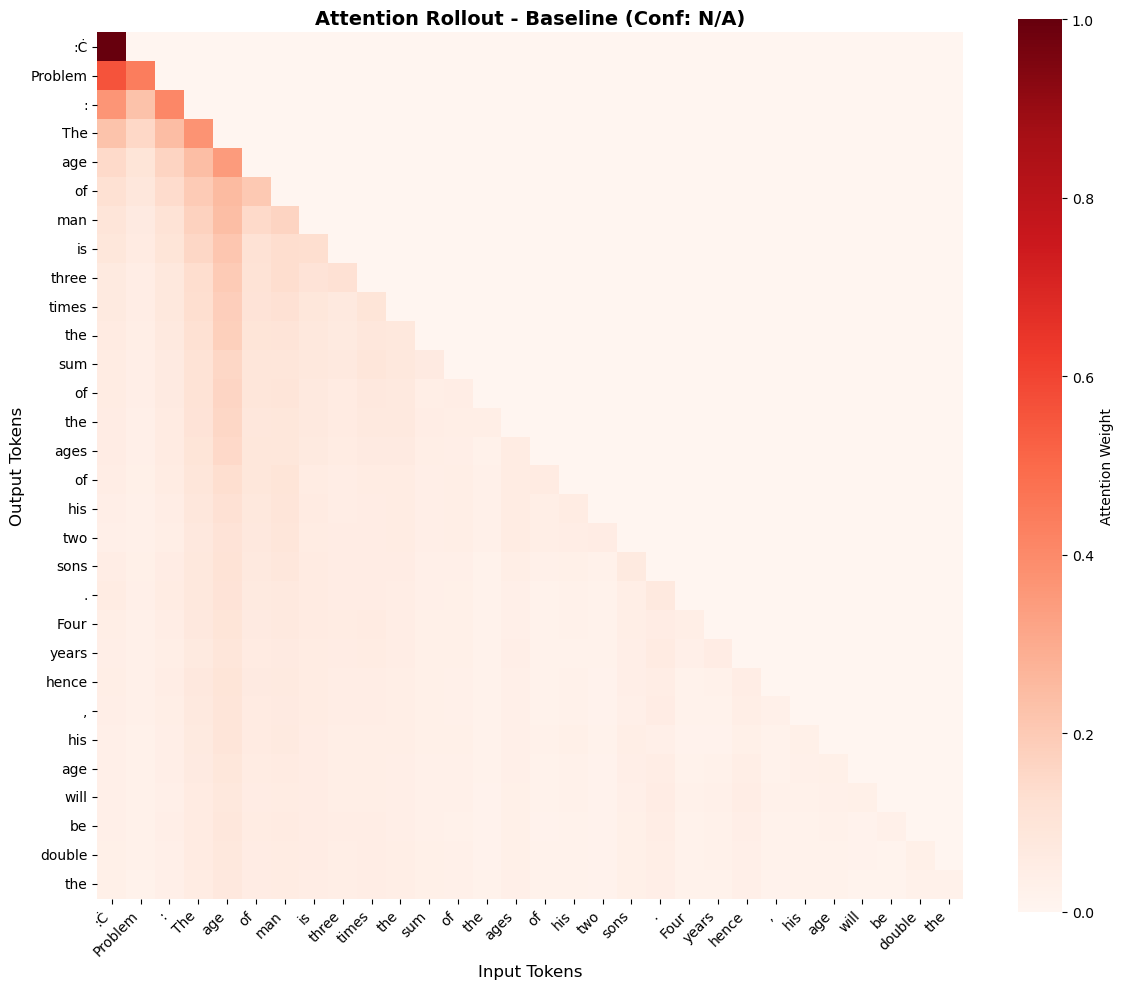


KEY TOKEN METRICS - Sample 1 (Row 0, Prompt_1)
Top 5 tokens by average rollout attention:
  1. age: 0.1237
  2. :Ċ: 0.1211
  3. The: 0.1014
  4. :: 0.0778
  5. of: 0.0702

Rollout Distribution Metrics:
  Mean attention per token: 0.0333
  Std attention per token: 0.0352
  Max attention: 0.1237
  Min attention: 0.0008
  Attention uniformity: -0.1159


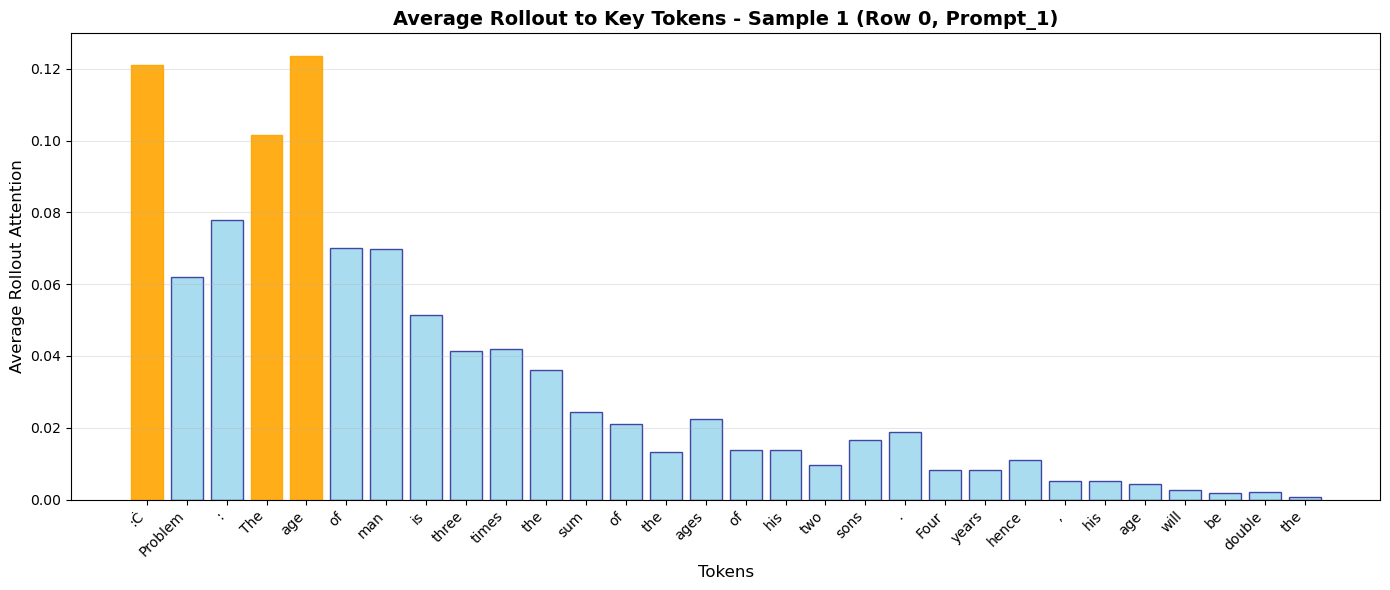


COMPLETE ATTENTION ANALYSIS - Sample 2 (Row 1, Prompt_1)
Category: Authority variant (1)
Prediction Confidence: N/A
Sequence Length: 127


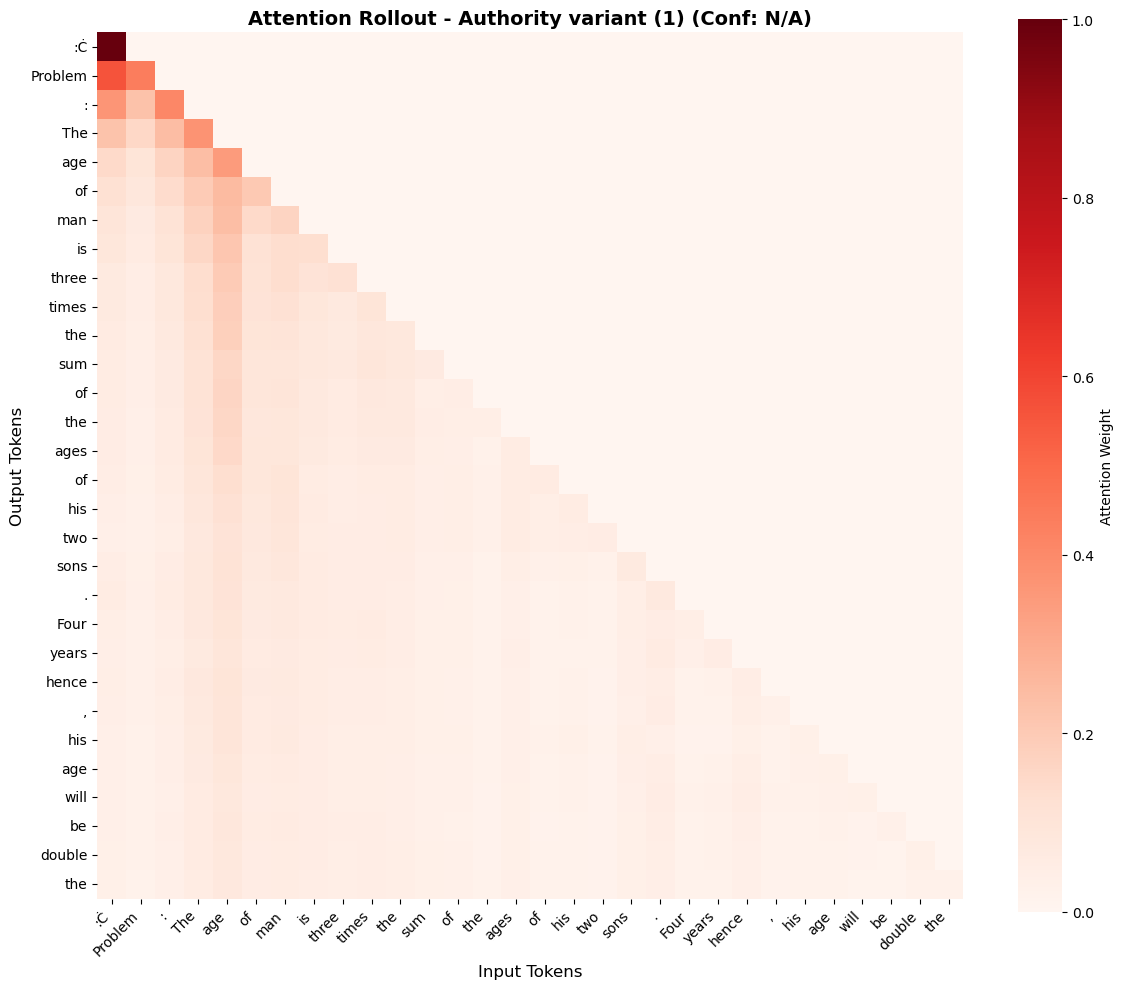


KEY TOKEN METRICS - Sample 2 (Row 1, Prompt_1)
Top 5 tokens by average rollout attention:
  1. age: 0.1237
  2. :Ċ: 0.1211
  3. The: 0.1014
  4. :: 0.0778
  5. of: 0.0702

Rollout Distribution Metrics:
  Mean attention per token: 0.0333
  Std attention per token: 0.0352
  Max attention: 0.1237
  Min attention: 0.0008
  Attention uniformity: -0.1159


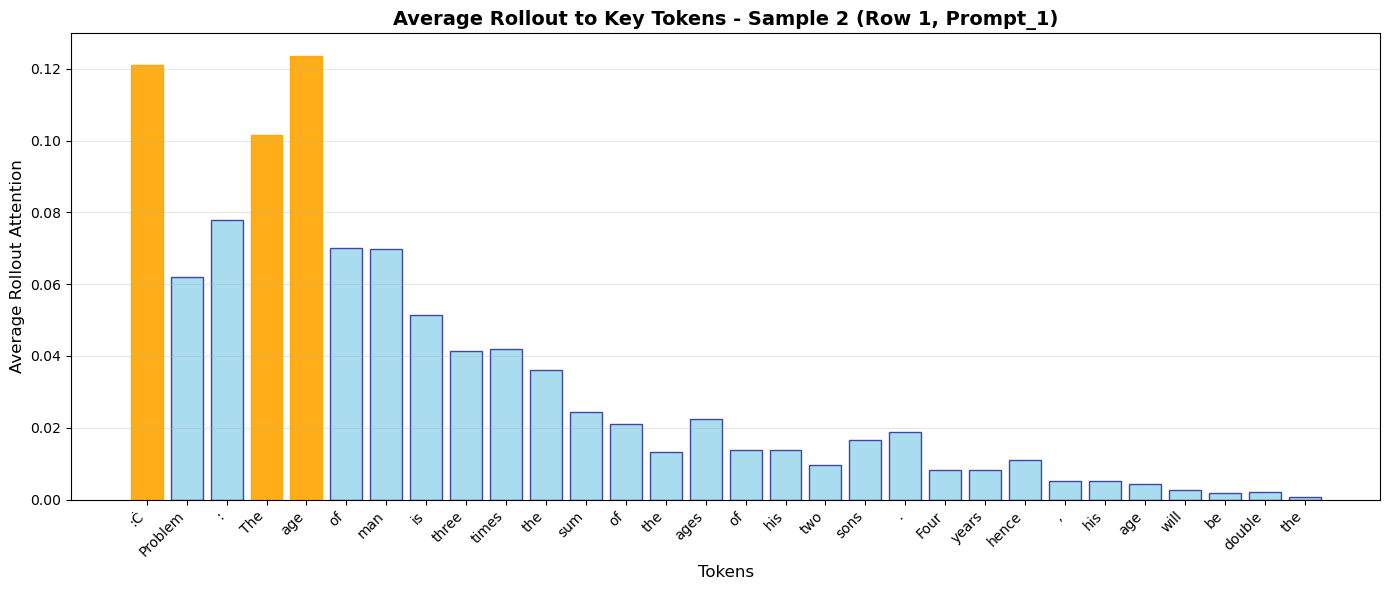


COMPLETE ATTENTION ANALYSIS - Sample 3 (Row 1, Prompt_2)
Category: Authority variant (1)
Prediction Confidence: 30.000
Sequence Length: 142


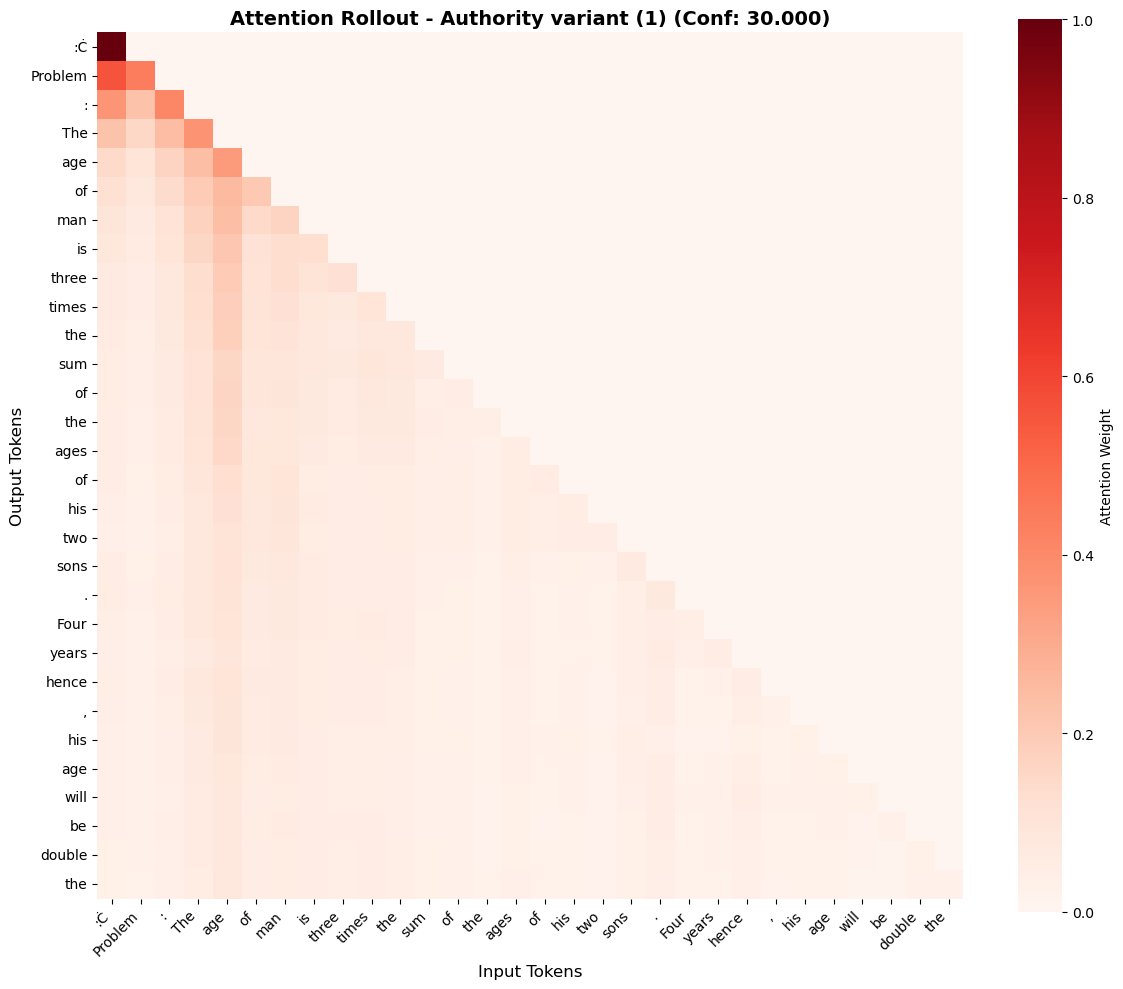


KEY TOKEN METRICS - Sample 3 (Row 1, Prompt_2)
Top 5 tokens by average rollout attention:
  1. age: 0.1237
  2. :Ċ: 0.1211
  3. The: 0.1014
  4. :: 0.0778
  5. of: 0.0702

Rollout Distribution Metrics:
  Mean attention per token: 0.0333
  Std attention per token: 0.0352
  Max attention: 0.1237
  Min attention: 0.0008
  Attention uniformity: -0.1159


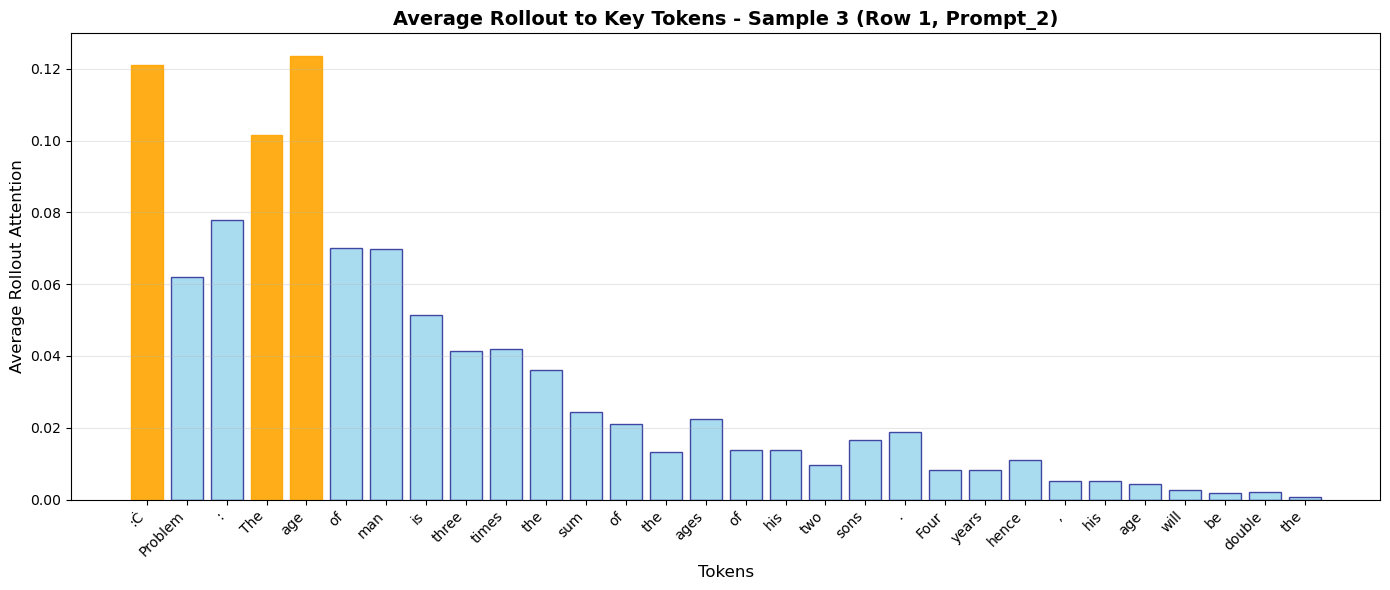


ANALYSIS COMPLETE
Final Results:
  Complete integrations analyzed: 20
  Visualizations generated: True

Analysis completed!


In [7]:


# Configuration
MIN_CORRELATION_THRESHOLD = 0.1  # Minimum correlation to report
SIGNIFICANCE_LEVEL = 0.05  # P-value threshold for significance
VISUALIZE_CORRELATIONS = False  # Set to True to create correlation plots
VISUALIZE_ATTENTION_PATTERNS = True  # Set to True to create attention heatmaps
MAX_SAMPLES_TO_VISUALIZE = 3  # Maximum samples for attention visualization

class BertVizStyleVisualizer:
    """Generate heatmaps and metrics similar to rollout paper"""

    def __init__(self):
        self.colormap = 'Blues'

        
    def create_attention_flow_graph(self, raw_attention_weights: np.ndarray,
                                   tokens: List[str], sample_id: str = ""):
        """
        Create attention flow network graph similar to the reference

        Args:
            raw_attention_weights: Raw attention [num_layers, heads, seq, seq]
            tokens: List of tokens
            sample_id: Sample identifier
        """
        import matplotlib.patches as patches

        if raw_attention_weights is None:
            print(f"No raw attention weights available for network graph - {sample_id}")
            return

        num_layers, num_heads, seq_len, _ = raw_attention_weights.shape

        # Average over heads for each layer
        layer_attention = np.mean(raw_attention_weights, axis=1)  # [layers, seq, seq]

        fig, ax = plt.subplots(figsize=(18, 12))

        # Truncate for visualization if too many tokens
        if seq_len > 20:
            tokens_viz = tokens[:20]
            layer_attention_viz = layer_attention[:, :20, :20]
            seq_len_viz = 20
        else:
            tokens_viz = tokens
            layer_attention_viz = layer_attention
            seq_len_viz = seq_len

        # Position tokens vertically and layers horizontally
        layer_spacing = 1.0
        token_spacing = 0.8

        # Draw tokens at each layer
        for layer_idx in range(num_layers):
            for token_idx in range(seq_len_viz):
                x = layer_idx * layer_spacing
                y = (seq_len_viz - token_idx - 1) * token_spacing  # Reverse for top-to-bottom

                # Draw token node (green dots)
                circle = patches.Circle((x, y), 0.08, facecolor='green',
                                      edgecolor='darkgreen', alpha=0.9, zorder=3)
                ax.add_patch(circle)

        # Draw attention connections between layers
        for layer_idx in range(num_layers - 1):
            attention_matrix = layer_attention_viz[layer_idx]  # [seq, seq]

            for from_token in range(seq_len_viz):
                for to_token in range(seq_len_viz):
                    attention_weight = attention_matrix[to_token, from_token]

                    # Only show connections above threshold
                    if attention_weight > 0.01:
                        x1 = layer_idx * layer_spacing
                        y1 = (seq_len_viz - from_token - 1) * token_spacing
                        x2 = (layer_idx + 1) * layer_spacing
                        y2 = (seq_len_viz - to_token - 1) * token_spacing

                        # Line properties based on attention weight
                        alpha = min(attention_weight * 8, 0.8)  # Scale alpha
                        linewidth = max(attention_weight * 3, 0.3)  # Scale thickness

                        # Draw connection line (blue)
                        ax.plot([x1, x2], [y1, y2], 'b-',
                               alpha=alpha, linewidth=linewidth, zorder=1)

        # Add token labels on the left
        for token_idx, token in enumerate(tokens_viz):
            y_pos = (seq_len_viz - token_idx - 1) * token_spacing
            ax.text(-0.4, y_pos, token,
                   ha='right', va='center', fontsize=11, fontweight='bold')

        # Add layer labels on top
        for layer_idx in range(num_layers):
            x_pos = layer_idx * layer_spacing
            ax.text(x_pos, seq_len_viz * token_spacing + 0.3, f'L{layer_idx}',
                   ha='center', va='bottom', fontsize=12, fontweight='bold')

        # Set plot limits and formatting
        ax.set_xlim(-0.6, (num_layers - 1) * layer_spacing + 0.2)
        ax.set_ylim(-0.4, seq_len_viz * token_spacing + 0.6)
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title(f'Attention Flow Network - {sample_id}', fontsize=16, fontweight='bold', pad=20)

        # Add description
        ax.text(0.02, 0.98, 'Green dots: Token positions\nBlue lines: Attention connections\nLine thickness: Attention weight',
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        plt.tight_layout()
        plt.show()

        return {
            'num_layers': num_layers,
            'sequence_length': seq_len_viz,
            'total_connections': np.sum(layer_attention_viz > 0.01),
            'avg_attention_per_layer': [np.mean(layer_attention_viz[i]) for i in range(num_layers)]
        }
    

    def create_attention_rollout_heatmap(self, normalized_rollout: np.ndarray, tokens: List[str],
                                       title: str = "Attention Rollout"):
        """
        Generate heatmap from normalized rollout (adapted from bert_viz.ipynb)

        Args:
            normalized_rollout: Normalized rollout matrix [seq_len, seq_len]
            tokens: List of tokens
            title: Plot title
        """
        plt.figure(figsize=(12, 10))

        # Create heatmap similar to bert_viz
        sns.heatmap(normalized_rollout,
                   xticklabels=tokens,
                   yticklabels=tokens,
                   cmap='Reds',  # Classic attention heatmap color
                   cbar_kws={'label': 'Attention Weight'},
                   square=True,
                   annot=len(tokens) < 15,  # Show values for small matrices
                   fmt='.3f')

        plt.title(title, fontsize=14, fontweight='bold')
        plt.xlabel('Input Tokens', fontsize=12)
        plt.ylabel('Output Tokens', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()


    def plot_bias_token_rollout(normalized_rollout_history: np.ndarray,
                                tokens: list,
                                bias_token_str: str):
        """
        NOT FULLY INTEGRATED INTO OBJECT STRUCTURE
        15Aug25
        Plot how a chosen bias token attends to all other tokens across layers.

        Args:
            normalized_rollout_history: np.ndarray [num_layers, seq_len, seq_len]
            tokens: list of token strings
            bias_token_str: token string to analyze (must exist in tokens)
        """
        import numpy as np
        import seaborn as sns
        import matplotlib.pyplot as plt

        # Find the index of the bias token
        try:
            s_position = tokens.index(bias_token_str)
        except ValueError:
            raise ValueError(f"Bias token '{bias_token_str}' not found in tokens list.")

        # Target positions = all except the bias token itself
        t_positions = [i for i in range(len(tokens)) if i != s_position]

        # Extract rollout attention for bias token across all layers
        bias_att = np.flip(normalized_rollout_history[:, s_position, t_positions], axis=0)

        # Axis labels
        xtick_labels = [tokens[i] for i in t_positions]
        num_layers = normalized_rollout_history.shape[0]
        ytick_labels = [str(i) if i % 2 == 0 else '' for i in range(num_layers, 0, -1)]

        # Plot
        plt.figure(figsize=(10, 6))
        sns.heatmap(bias_att,
                    xticklabels=xtick_labels,
                    yticklabels=ytick_labels,
                    cmap="YlOrRd",
                    cbar_kws={'label': 'Rollout Attention'})
        plt.title(f"Rollout Attention from '{bias_token_str}' to Other Tokens", fontsize=14, fontweight='bold')
        plt.xlabel('Target Tokens')
        plt.ylabel('Layer')
        plt.tight_layout()
        plt.show()


    def create_raw_attention_comparison(self, raw_attention_weights: np.ndarray,
                                      normalized_rollout: np.ndarray, tokens: List[str],
                                      sample_id: str = ""):
        """
        Compare raw attention vs rollout [THIS METHOD IS MOST LIKELY WRONG]

        Args:
            raw_attention_weights: Raw attention [num_layers, heads, seq, seq]
            normalized_rollout: Final normalized rollout [seq, seq]
            tokens: List of tokens
            sample_id: Sample identifier
        """
        if raw_attention_weights is None:
            print(f"No raw attention weights available for {sample_id}")
            return

        num_layers = raw_attention_weights.shape[0]

        # Show last layer raw attention (averaged over heads)
        last_layer_attention = np.mean(raw_attention_weights[-1], axis=0)  # Average over heads

        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Raw attention (last layer)
        sns.heatmap(last_layer_attention,
                   xticklabels=tokens, yticklabels=tokens,
                   cmap='Blues', square=True, ax=axes[0],
                   cbar_kws={'label': 'Raw Attention'})
        axes[0].set_title(f'Raw Attention (Last Layer) - {sample_id}')
        axes[0].set_xlabel('Input Tokens')
        axes[0].set_ylabel('Output Tokens')

        # Normalized rollout
        sns.heatmap(normalized_rollout,
                   xticklabels=tokens, yticklabels=tokens,
                   cmap='Reds', square=True, ax=axes[1],
                   cbar_kws={'label': 'Rollout Attention'})
        axes[1].set_title(f'Attention Rollout - {sample_id}')
        axes[1].set_xlabel('Input Tokens')
        axes[1].set_ylabel('Output Tokens')
        plt.tight_layout()
        plt.show()
        

    def compute_and_visualize_key_token_metrics(self, normalized_rollout: np.ndarray,
                                              tokens: List[str], sample_id: str = ""):
        """
        Compute metrics: avg rollout to key tokens

        Args:
            normalized_rollout: Normalized rollout matrix
            tokens: List of tokens
            sample_id: Sample identifier
        """
        # Compute average rollout to each token (average attention each token receives)
        avg_rollout_to_tokens = np.mean(normalized_rollout, axis=0)

        print(f"\n{'='*60}")
        print(f"KEY TOKEN METRICS - {sample_id}")
        print(f"{'='*60}")

        # Find top attended tokens
        top_indices = np.argsort(avg_rollout_to_tokens)[-5:][::-1]  # Top 5, reversed

        print(f"Top 5 tokens by average rollout attention:")
        for i, idx in enumerate(top_indices):
            if idx < len(tokens):
                token = tokens[idx]
                attention = avg_rollout_to_tokens[idx]
                print(f"  {i+1}. {token}: {attention:.4f}")

        # Compute additional metrics
        print(f"\nRollout Distribution Metrics:")
        print(f"  Mean attention per token: {np.mean(avg_rollout_to_tokens):.4f}")
        print(f"  Std attention per token: {np.std(avg_rollout_to_tokens):.4f}")
        print(f"  Max attention: {np.max(avg_rollout_to_tokens):.4f}")
        print(f"  Min attention: {np.min(avg_rollout_to_tokens):.4f}")
        print(f"  Attention uniformity: {1.0 - np.var(avg_rollout_to_tokens) / np.mean(avg_rollout_to_tokens)**2:.4f}")

        # Create bar plot of average rollout to tokens
        plt.figure(figsize=(14, 6))

        bars = plt.bar(range(len(tokens)), avg_rollout_to_tokens,
                      color='skyblue', alpha=0.7, edgecolor='navy')

        # Highlight top tokens
        for idx in top_indices[:3]:  # Highlight top 3
            if idx < len(bars):
                bars[idx].set_color('orange')
                bars[idx].set_alpha(0.9)

        plt.title(f'Average Rollout to Key Tokens - {sample_id}', fontsize=14, fontweight='bold')
        plt.xlabel('Tokens', fontsize=12)
        plt.ylabel('Average Rollout Attention', fontsize=12)
        plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

        rollout_stats = {
            'avg_rollout_to_tokens': avg_rollout_to_tokens,
            'top_tokens': [(tokens[idx], avg_rollout_to_tokens[idx]) for idx in top_indices if idx < len(tokens)],
            'distribution_metrics': {
                'mean': np.mean(avg_rollout_to_tokens),
                'std': np.std(avg_rollout_to_tokens),
                'max': np.max(avg_rollout_to_tokens),
                'min': np.min(avg_rollout_to_tokens)
            }
        }
        
        return rollout_stats
    

    def visualize_complete_sample(self, integration_result: Dict, sample_id: str = ""):
        """
        Complete visualization of integrated sample (attention + predictions)

        Args:
            integration_result: Complete integration result from Script 5
            sample_id: Sample identifier
        """
        if not integration_result or integration_result['integration_quality'] != 'complete':
            print(f"Warning: Incomplete integration for {sample_id}")
            return

        attention_data = integration_result['attention_analysis']
        prediction_data = integration_result['prediction_analysis']

        # Extract data
        normalized_rollout = attention_data['normalized_rollout']
        attention_metrics = attention_data['attention_metrics']
        tokens = attention_data['tokens']

        # Get raw attention if available
        raw_attention = attention_data.get('raw_attention_weights')

        # Prediction info
        category = prediction_data['row_metadata']['category']
        confidence = prediction_data['prediction_confidence']
        conf_str = f"{confidence:.3f}" if confidence is not None else "N/A"

        print(f"\n{'='*80}")
        print(f"COMPLETE ATTENTION ANALYSIS - {sample_id}")
        print(f"Category: {category}")
        print(f"Prediction Confidence: {conf_str}")
        print(f"Sequence Length: {len(tokens)}")
        print(f"{'='*80}")

        # Truncate for visualization if too long
        if len(tokens) > 30:
            tokens_viz = tokens[:30]
            rollout_viz = normalized_rollout[:30, :30]
            raw_attention_viz = raw_attention[:, :, :30, :30] if raw_attention is not None else None
        else:
            tokens_viz = tokens
            rollout_viz = normalized_rollout
            raw_attention_viz = raw_attention

        # 1. Main rollout heatmap
        self.create_attention_rollout_heatmap(
            rollout_viz, tokens_viz,
            f"Attention Rollout - {category} (Conf: {conf_str})"
        )

        # 3. Attention flow network graph
        if raw_attention_viz is not None:
            flow_metrics = self.create_attention_flow_graph(
                raw_attention_viz, tokens_viz, sample_id
            )

        # 4. Raw vs rollout comparison
        if raw_attention_viz is not None:
            self.create_raw_attention_comparison(
                raw_attention_viz, rollout_viz, tokens_viz, sample_id
            )

        # 5. Key token metrics
        key_metrics = self.compute_and_visualize_key_token_metrics(
            rollout_viz, tokens_viz, sample_id
        )

        return {
            'key_metrics': key_metrics,
            'flow_metrics': flow_metrics if 'flow_metrics' in locals() else None,
            'visualization_info': {
                'tokens_shown': len(tokens_viz),
                'total_tokens': len(tokens),
                'truncated': len(tokens) > 30
            }
        }

    
class AttentionPredictionCorrelator: # Think this is useless...
    """Analyze correlations between attention patterns and predictions"""

    def __init__(self, min_correlation: float = 0.1, significance_level: float = 0.05):
        self.min_correlation = min_correlation
        self.significance_level = significance_level
        self.visualizer = BertVizStyleVisualizer()

    def extract_attention_features(self, attention_metrics: Dict) -> Dict:
        """Extract scalar features from attention metrics for correlation analysis"""
        features = {
            'mean_entropy': float(np.mean(attention_metrics['attention_entropy'])),
            'std_entropy': float(np.std(attention_metrics['attention_entropy'])),
            'max_entropy': float(np.max(attention_metrics['attention_entropy'])),

            'mean_concentration': float(np.mean(attention_metrics['attention_concentration'])),
            'std_concentration': float(np.std(attention_metrics['attention_concentration'])),
            'max_concentration': float(np.max(attention_metrics['attention_concentration'])),

            'mean_max_attention': float(np.mean(attention_metrics['max_attention_values'])),
            'global_max_attention': float(np.max(attention_metrics['max_attention_values'])),

            'total_attention_flow': float(attention_metrics['total_attention_flow']),
            'attention_variance': float(np.var(attention_metrics['avg_attention_to_tokens'])),
            'attention_uniformity': 1.0 - float(np.var(attention_metrics['avg_attention_to_tokens'])) / float(np.mean(attention_metrics['avg_attention_to_tokens'])**2)
        }

        return features
    

    def compute_correlations(self, integrated_data: Dict) -> Dict:
        """Compute correlations between attention features and prediction features"""
        attention_features_list = []
        prediction_features_list = []
        sample_metadata = []

        for row_idx, row_data in integrated_data.items():
            for prompt_col, integration_result in row_data.items():
                if (integration_result and
                    integration_result['integration_quality'] == 'complete'):

                    attention_data = integration_result['attention_analysis']
                    prediction_data = integration_result['prediction_analysis']

                    # Extract attention features
                    attention_features = self.extract_attention_features(
                        attention_data['attention_metrics']
                    )

                    # Extract prediction features
                    prediction_features = {
                        'confidence': prediction_data['prediction_confidence'],
                        'text_length': prediction_data['text_features']['text_length'],
                        'word_count': prediction_data['text_features']['word_count'],
                        'confidence_words': prediction_data['text_features']['confidence_words'],
                        'uncertainty_words': prediction_data['text_features']['uncertainty_words'],
                        'has_numbers': int(prediction_data['text_features']['has_numbers']),
                        'has_answer_phrase': int(prediction_data['text_features']['has_answer_phrase']),
                        'has_authority_reference': int(prediction_data['text_features']['has_authority_reference'])
                    }

                    attention_features_list.append(attention_features)
                    prediction_features_list.append(prediction_features)
                    sample_metadata.append({
                        'row_idx': row_idx,
                        'prompt_col': prompt_col,
                        'category': prediction_data['row_metadata']['category']
                    })

        if not attention_features_list:
            return {'error': 'No complete integration samples found'}

        # Convert to DataFrames
        attention_df = pd.DataFrame(attention_features_list)
        prediction_df = pd.DataFrame(prediction_features_list)

        # Compute correlations
        correlations = {}

        for att_feature in attention_df.columns:
            correlations[att_feature] = {}

            for pred_feature in prediction_df.columns:
                att_values = attention_df[att_feature].values
                pred_values = prediction_df[pred_feature].values

                if (np.var(pred_values) > 0 and
                    not np.any(pd.isna(att_values)) and
                    not np.any(pd.isna(pred_values))):

                    pearson_corr, pearson_p = pearsonr(att_values, pred_values)
                    spearman_corr, spearman_p = spearmanr(att_values, pred_values)

                    correlations[att_feature][pred_feature] = {
                        'pearson_r': pearson_corr,
                        'pearson_p': pearson_p,
                        'spearman_r': spearman_corr,
                        'spearman_p': spearman_p,
                        'n_samples': len(att_values),
                        'significant': min(pearson_p, spearman_p) < self.significance_level
                    }

        return {
            'correlations': correlations,
            'n_samples': len(attention_features_list),
            'sample_metadata': sample_metadata
        }
    

    def create_correlation_heatmap(self, correlation_results: Dict):
        """Create correlation heatmap visualization"""
        if not VISUALIZE_CORRELATIONS or 'correlations' not in correlation_results:
            return

        correlations = correlation_results['correlations']

        # Build correlation matrix
        attention_features = list(correlations.keys())
        prediction_features = list(correlations[attention_features[0]].keys())

        corr_matrix = np.zeros((len(attention_features), len(prediction_features)))
        p_matrix = np.zeros((len(attention_features), len(prediction_features)))

        for i, att_feature in enumerate(attention_features):
            for j, pred_feature in enumerate(prediction_features):
                corr_data = correlations[att_feature][pred_feature]
                corr_matrix[i, j] = corr_data['pearson_r']
                p_matrix[i, j] = corr_data['pearson_p']

        # Create heatmap
        plt.figure(figsize=(12, 8))

        mask = p_matrix >= self.significance_level

        sns.heatmap(corr_matrix,
                   xticklabels=prediction_features,
                   yticklabels=attention_features,
                   mask=mask,
                   annot=True,
                   fmt='.3f',
                   cmap='RdBu_r',
                   center=0,
                   vmin=-1, vmax=1)

        plt.title(f'Attention-Prediction Correlations\n(Only significant correlations shown, p < {self.significance_level})')
        plt.xlabel('Prediction Features')
        plt.ylabel('Attention Features')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        

    def analyze_and_visualize_samples(self, integrated_data: Dict, max_samples: int = 3):
        """Analyze and visualize sample cases"""
        if not VISUALIZE_ATTENTION_PATTERNS:
            return

        # Find diverse samples
        sample_indices = []
        categories_seen = set()
        count = 0

        for row_idx, row_data in integrated_data.items():
            for prompt_col, integration_result in row_data.items():
                if (integration_result and
                    integration_result['integration_quality'] == 'complete' and
                    count < max_samples):

                    category = integration_result['prediction_analysis']['row_metadata']['category']

                    if category not in categories_seen or len(categories_seen) < 3:
                        sample_indices.append((row_idx, prompt_col))
                        categories_seen.add(category)
                        count += 1

        # Visualize samples
        for i, (row_idx, prompt_col) in enumerate(sample_indices):
            if row_idx in integrated_data and prompt_col in integrated_data[row_idx]:
                integration_result = integrated_data[row_idx][prompt_col]
                sample_id = f"Sample {i+1} (Row {row_idx}, {prompt_col})"
                self.visualizer.visualize_complete_sample(integration_result, sample_id)

                
# Execute final analysis and visualization
if __name__ == "__main__":
    print("Final Analysis and Visualization")
    print("-" * 40)

    # Check if integrated data is available from Script 5
    if 'integrated_data' not in globals():
        print("Error: No integrated data found. Run Scripts 1-5 first.")
        exit()

    # Initialize analyzer
    correlator = AttentionPredictionCorrelator(
        min_correlation=MIN_CORRELATION_THRESHOLD,
        significance_level=SIGNIFICANCE_LEVEL
    )

    print(f"Generating heatmaps and computing metrics")
    print(f"Configuration:")
    print(f"  Correlation threshold: {MIN_CORRELATION_THRESHOLD}")
    print(f"  Significance level: {SIGNIFICANCE_LEVEL}")
    print(f"  Visualize correlations: {VISUALIZE_CORRELATIONS}")
    print(f"  Visualize attention patterns: {VISUALIZE_ATTENTION_PATTERNS}")

    # Count complete integrations
    complete_samples = 0
    for row_idx, row_data in integrated_data.items():
        for prompt_col, integration_result in row_data.items():
            if (integration_result and
                integration_result['integration_quality'] == 'complete'):
                complete_samples += 1

    print(f"Complete integration samples: {complete_samples}")

    # Step 6A: Compute correlations between attention and predictions
    if VISUALIZE_CORRELATIONS:
        print(f"\nComputing attention-prediction correlations...")
        correlation_results = correlator.compute_correlations(integrated_data)

        if 'error' in correlation_results:
            print(f"Error: {correlation_results['error']}")
        else:
            print(f"Analyzed {correlation_results['n_samples']} complete samples")

            # Create correlation heatmap
            correlator.create_correlation_heatmap(correlation_results)

            # Find significant correlations
            significant_correlations = []
            correlations = correlation_results['correlations']

            for att_feature, pred_correlations in correlations.items():
                for pred_feature, corr_data in pred_correlations.items():
                    if corr_data['significant']:
                        max_corr = max(abs(corr_data['pearson_r']), abs(corr_data['spearman_r']))
                        if max_corr >= MIN_CORRELATION_THRESHOLD:
                            significant_correlations.append({
                                'attention_feature': att_feature,
                                'prediction_feature': pred_feature,
                                'pearson_r': corr_data['pearson_r'],
                                'spearman_r': corr_data['spearman_r'],
                                'max_abs_correlation': max_corr,
                                'p_value': min(corr_data['pearson_p'], corr_data['spearman_p'])
                            })

            # Sort by correlation strength
            significant_correlations.sort(key=lambda x: x['max_abs_correlation'], reverse=True)

            print(f"\nSignificant Correlations Found: {len(significant_correlations)}")
            for i, corr in enumerate(significant_correlations[:5]):  # Show top 5
                print(f"  {i+1}. {corr['attention_feature']} ↔ {corr['prediction_feature']}")
                print(f"     Pearson r = {corr['pearson_r']:.3f}, Spearman r = {corr['spearman_r']:.3f}")
                print(f"     p < {corr['p_value']:.4f}")

    # Step 6B: Generate heatmaps and compute key token metrics
    if VISUALIZE_ATTENTION_PATTERNS:
        print(f"\nGenerating attention visualizations for {MAX_SAMPLES_TO_VISUALIZE} samples...")
        correlator.analyze_and_visualize_samples(integrated_data, MAX_SAMPLES_TO_VISUALIZE)

    # Step 6C: Summary of analysis
    print(f"\n{'='*60}")
    print(f"ANALYSIS COMPLETE")
    print(f"{'='*60}")

    print(f"Final Results:")
    print(f"  Complete integrations analyzed: {complete_samples}")
    if VISUALIZE_CORRELATIONS and 'correlation_results' in locals():
        if 'correlations' in correlation_results:
            print(f"  Significant correlations found: {len(significant_correlations)}")
    print(f"  Visualizations generated: {VISUALIZE_ATTENTION_PATTERNS}")

    # Export final results
    globals()['final_correlator'] = correlator
    if 'correlation_results' in locals():
        globals()['final_correlation_results'] = correlation_results
        globals()['significant_correlations'] = significant_correlations

    print(f"\nAnalysis completed!")

## Bias token rollout heatmap for thesis

In [26]:
def plot_bias_token_rollout(normalized_rollout_history: np.ndarray,
                            tokens: list,
                            bias_token_str: str):
    """
    Plot how a chosen bias token attends to all other tokens across layers.

    Args:
        normalized_rollout_history: np.ndarray [num_layers, seq_len, seq_len]
        tokens: list of token strings
        bias_token_str: token string to analyze (must exist in tokens)
    """
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Find the index of the bias token
    try:
        s_position = tokens.index(bias_token_str)
    except ValueError:
        raise ValueError(f"Bias token '{bias_token_str}' not found in tokens list.")

    # Target positions = all except the bias token itself
    t_positions = [i for i in range(len(tokens)) if i != s_position]
    # t_positions = [i for i in range(len(tokens))]
    

    # Extract rollout attention for bias token across all layers
    bias_att = np.flip(normalized_rollout_history[:, s_position, t_positions], axis=0)

    # Axis labels
    xtick_labels = [tokens[i] for i in t_positions]
    num_layers = normalized_rollout_history.shape[0]
    ytick_labels = [str(i) if i % 2 == 0 else '' for i in range(num_layers, 0, -1)]

    # Plot
    plt.figure(figsize=(18, 6))
    sns.heatmap(bias_att,
                xticklabels=xtick_labels,
                yticklabels=ytick_labels,
                cmap="YlOrRd",
                cbar_kws={'label': 'Rollout Attention'})
    plt.title(f"Rollout Attention from '{bias_token_str}' to Other Tokens", fontsize=14, fontweight='bold')
    plt.xlabel('Target Tokens')
    plt.ylabel('Layer')
    plt.tight_layout()
    plt.show()

In [34]:
normalized_rollout_history = all_normalized_data[4]['Prompt_3']['normalized_rollout_history_array']
normalized_rollout_history.shape

(17, 139, 139)

In [35]:
tokens = all_normalized_data[4]['Prompt_3']['tokens'][:-1]
bias_tokens = 'unsure'

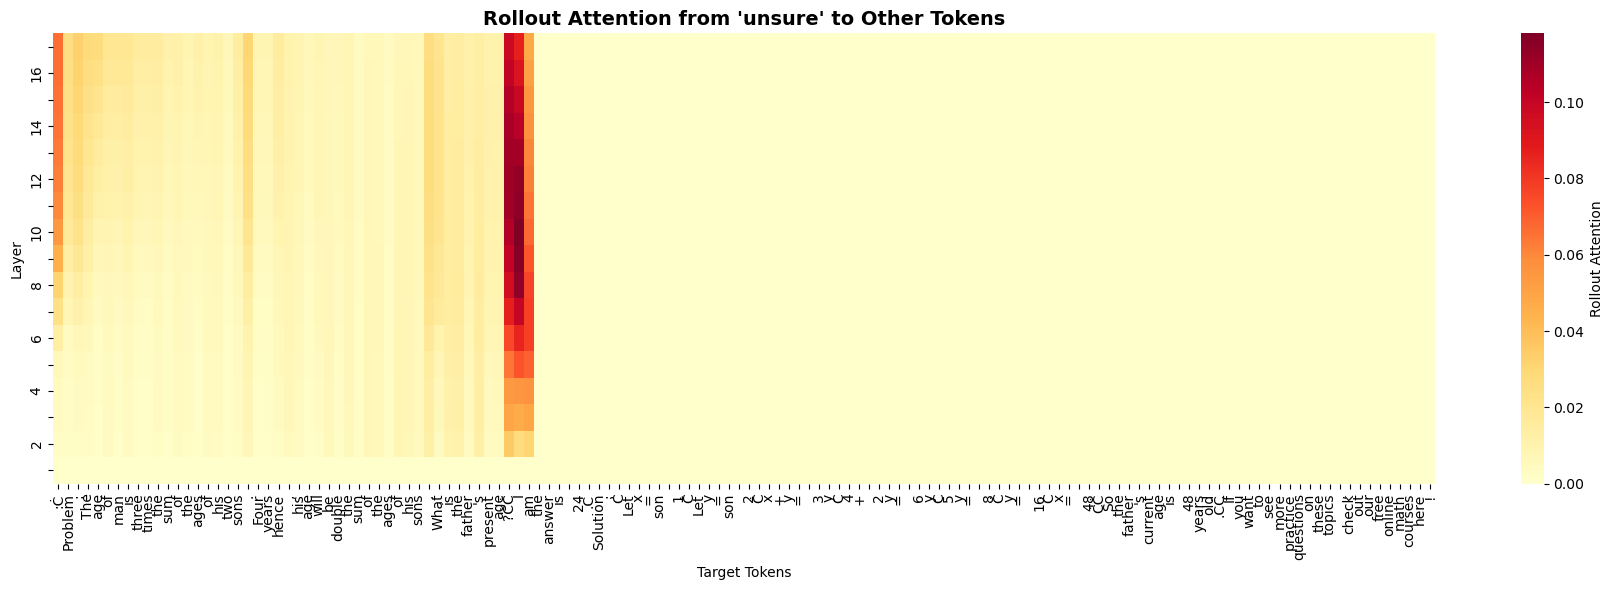

In [36]:
plot_bias_token_rollout(normalized_rollout_history,
                        tokens,
                        bias_tokens)